In [1]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go


import warnings
# Suppress all SettingWithCopyWarning warnings
warnings.filterwarnings("ignore", category=pd.errors.SettingWithCopyWarning)

# Introduction

- How i did this workbook mimicks how I would present to a senior team member during the first stages of a project.
- I started by tried many different methods and included the thoughts behind it for further discussion. 
- I've also explored data beyond what is provided, mimicking how I would do the task in a real job setting.

# Question 1 and 2
1 Forecast the Year-over-year percent change in Brand Comparable Sales (also known as “Same Store Sales”) for Party City (NYSE: PRTY) for the period ending 12/31/2022 using the provided transaction data and store location information. The data to complete the request can be found in the following files. 

Note: the transaction data is collected from roughly a 1% sample of the US population.
“system2_case_study_reported_numbers.xlsx”
“system2_case_study_transaction_data_location_info.csv”
“system2_case_study_transaction_data_monthly_sales_by_locationid.csv”

2 Party City was delisted on January 18, 2023, by the NYSE. However, at the time of the bankruptcy filing, Party City had ~1.7B in debt, and after the restructuring was complete, Party City still had ~700M in debt. The entity is still interesting for some credit-focused investors, but the company is no longer required to report its performance publicly. Please forecast the Year over Year percent change in Brand Comparable Sales for the periods ending 3/31/2023, 6/30/2023, and 9/30/2023.

Models:
1. Trivial model of taking the average over past years.
2. Regression model
3. SARIMA(X) model

Note: original intention was to try more complex ML methods such as RF and XGBoost. However, the regression result was essentially 'too good'. In the case where we have sales data, a regression model is good enough.

In [2]:
reported_numbers = pd.read_excel('system2_case_study_reported_numbers.xlsx')
transaction = pd.read_csv('system2_case_study_transaction_data_monthly_sales_by_locationid.csv')
location = pd.read_csv('system2_case_study_transaction_data_location_info.csv')

In [3]:
reported_numbers.head()

entity                            metric period_end_dt  reported_yoy
0   PRTY  Brand Comparable Sales Growth, %    2016-03-31        -0.015
1   PRTY  Brand Comparable Sales Growth, %    2016-06-30         0.038
2   PRTY  Brand Comparable Sales Growth, %    2016-09-30         0.012
3   PRTY  Brand Comparable Sales Growth, %    2016-12-31        -0.035
4   PRTY  Brand Comparable Sales Growth, %    2017-03-31         0.017

In [4]:
# Some abnormality in the locationid, many duplicated
print('Number of unique location ids (there are 898 rows altogether):', location.locationid.nunique())
location.sort_values(by='locationid').reset_index(drop=True).head(10)

Number of unique location ids (there are 898 rows altogether): 866


locationid               est_open_date              est_close_date
0           1  2017-01-01 00:00:00.000000  2024-09-01 00:00:00.000000
1           2  2018-07-01 00:00:00.000000  2020-10-01 00:00:00.000000
2           2  2017-01-01 00:00:00.000000  2024-09-01 00:00:00.000000
3           3  2017-01-01 00:00:00.000000  2020-09-01 00:00:00.000000
4           3  2017-01-01 00:00:00.000000  2022-07-01 00:00:00.000000
5           3  2017-04-01 00:00:00.000000  2024-09-01 00:00:00.000000
6           4  2018-07-01 00:00:00.000000  2024-09-01 00:00:00.000000
7          10  2017-01-01 00:00:00.000000  2024-09-01 00:00:00.000000
8          10  2017-01-01 00:00:00.000000  2024-09-01 00:00:00.000000
9          11  2017-01-01 00:00:00.000000  2023-11-01 00:00:00.000000

### Preliminary Observations:

1. For locations, we observe that locations 3 and 18 have 3 stores each, a number of stores have 2 values. The effect of havign multiple stores with one locationid can be solved by taking the sum of all earning amounts for each month, which reflects the total earning of the company.

2. We also note that reported numbers period start from 2016, but sales numbers start from 2019.

## EDA
When manipulating the transaction data to find the yoy sales change, we have 2 ways:

1. First, we can stick close to the definition of Brand Comparable Sales (also known as “Same Store Sales”), where we calculate the quarterly change for each store and then average it across all stores.
    - This helps to analyze from a very detailed angle but we need to remove a lot of data in this process (unable to identify locationids with multiple stores which open and close at different dates). 


2. Second, we could just take the sum of the total amount per month (total earnings) and calculate the yoy change per quarter.
    - This also works since we are mostly interested in the macro-level analysis of the overall performance of the company. We also take into account all the stores (regardless of whether they closed within a year). This has another benefit, which is that we can simplify the process of accounting for the closing or opening of stores. We only care about the end result of these additional factors, which is how much money they are earning. This simplifies the model greatly.



### Method 1 of calculating yoy sales (calculating from individual stores first)

In [5]:
# first way, cleaning up locations
location.est_open_date = pd.to_datetime(location.est_open_date)
location.est_close_date = pd.to_datetime(location.est_close_date)

# We want to remove all the stores which are open for less than 1 year, because in that way these locations are not open
# Calculate the difference in days between open and close dates
location['duration'] = (location['est_close_date'] - location['est_open_date']).dt.days

# Filter for locations with a duration of less than 365 days
short_duration_locations = location[location['duration'] < 365]['locationid'].tolist()
print('short duration locations:', short_duration_locations)

# We also want to remove all location ids have more than 1 store. for these stores, they do not have 
unique_location_ids = location['locationid'].value_counts()[location['locationid'].value_counts() == 1].index
unique_store = location[location['locationid'].isin(unique_location_ids)]['locationid'].tolist()
print('number of unique stores:', len(unique_store))

short duration locations: [290, 339]
number of unique stores: 836


In [6]:
# Converting to datetime
transaction['period_start'] = pd.to_datetime(transaction['period_start'])
transaction['period_end'] = pd.to_datetime(transaction['period_end'])

# Dropping unnecessary columns
transaction.drop(['symbol','label'], axis=1, inplace=True)

# Removing complex locationids from transaction data
tf = transaction[~transaction['locationid'].isin(short_duration_locations)]
tf = tf[tf['locationid'].isin(unique_store)]
print(transaction.shape, tf.shape)

(38867, 4) (36964, 4)


In [7]:
tf.set_index('period_end', inplace=True)

In [8]:
# calculating quarterly average for each location. Chose quarterly_avg because some locations may have started at months halfway through the quarter
quarterly_sales = tf.groupby('locationid').resample('Q')['amount'].mean().reset_index()
quarterly_sales.set_index('period_end', inplace=True)

In [9]:
# Calculate year-over-year percentage change for each location
quarterly_sales['yoy_percent_change'] = quarterly_sales.groupby('locationid')['amount'].pct_change(periods=4)
quarterly_sales.reset_index(inplace=True)

# Calculate the average overall yoy growth across all stores
overall_yoy_growth = pd.DataFrame(quarterly_sales.groupby('period_end')['yoy_percent_change'].mean())
overall_yoy_growth

/var/folders/l4/dt5s4bl514j41hts3r55lh6m0000gn/T/ipykernel_57392/1192605728.py:2: FutureWarning: The default fill_method='ffill' in SeriesGroupBy.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  quarterly_sales['yoy_percent_change'] = quarterly_sales.groupby('locationid')['amount'].pct_change(periods=4)


yoy_percent_change
period_end                    
2019-09-30                 NaN
2019-12-31                 NaN
2020-03-31                 NaN
2020-06-30                 NaN
2020-09-30            0.489320
2020-12-31            0.151058
2021-03-31            0.637161
2021-06-30            1.990966
2021-09-30            0.738442
2021-12-31            1.132387
2022-03-31            0.499227
2022-06-30            0.460400
2022-09-30            0.570701
2022-12-31            0.547477
2023-03-31            0.940175
2023-06-30            0.219951
2023-09-30            0.269828
2023-12-31            0.069606

/Users/matticii/anaconda3/lib/python3.11/site-packages/_plotly_utils/basevalidators.py:106: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  v = v.dt.to_pydatetime()


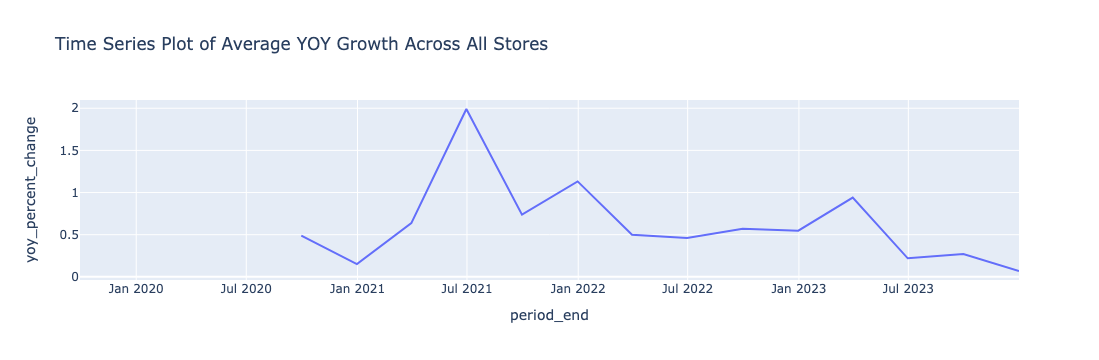

In [10]:
px.line(overall_yoy_growth, y = 'yoy_percent_change', title= "Time Series Plot of Average YOY Growth Across All Stores")

### Method 2 of calculating yoy sales (summing up total amount)

In [11]:
# Creating total transaction amount per month
transaction_month = transaction.groupby('period_end')['amount'].sum().reset_index()
transaction_month['year'] = transaction_month['period_end'].dt.year
transaction_month['quarter'] = transaction_month['period_end'].dt.quarter

/Users/matticii/anaconda3/lib/python3.11/site-packages/_plotly_utils/basevalidators.py:106: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



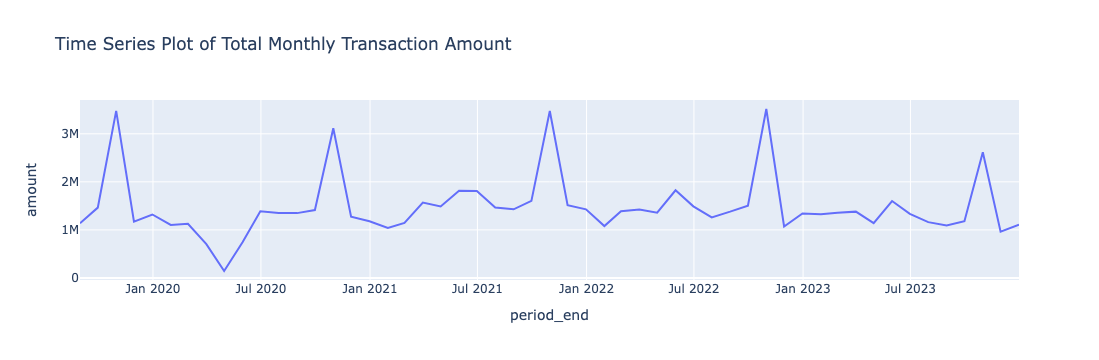

In [12]:
px.line(transaction_month, x = 'period_end', y = 'amount', title= "Time Series Plot of Total Monthly Transaction Amount")

In [13]:
# Creating summary for quarterly
transaction_quarter = transaction_month.groupby(['year', 'quarter'])['amount'].sum().reset_index()

quarter_end_month_map = {1: '03-31', 2: '06-30', 3: '09-30', 4: '12-31'}

# Create 'quarter_end_date' column by combining year and the last day of the quarter
transaction_quarter['quarter_end_dt'] = pd.to_datetime(transaction_quarter['year'].astype(str) + "-" + 
                                                    transaction_quarter['quarter'].map(quarter_end_month_map))

In [14]:
transaction_quarter['yoy_percent_change2'] = transaction_quarter['amount'].pct_change(periods=4)
transaction_quarter.set_index('quarter_end_dt', inplace=True)

/Users/matticii/anaconda3/lib/python3.11/site-packages/_plotly_utils/basevalidators.py:106: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



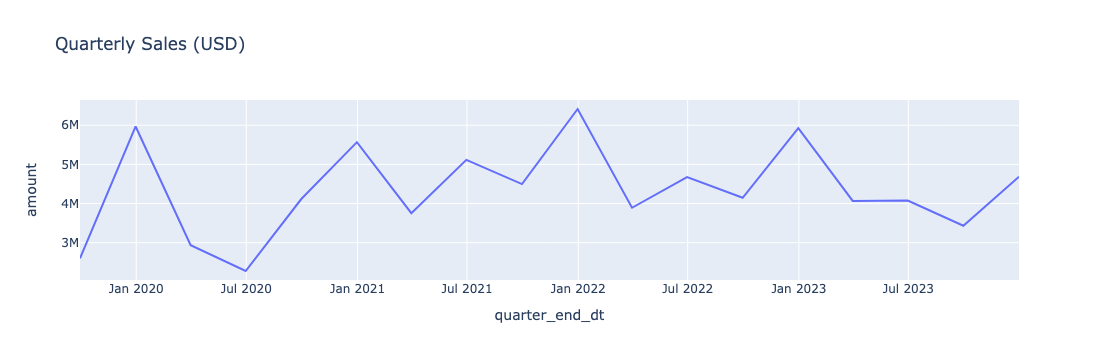

In [15]:
px.line(transaction_quarter, y = 'amount', title="Quarterly Sales (USD)")

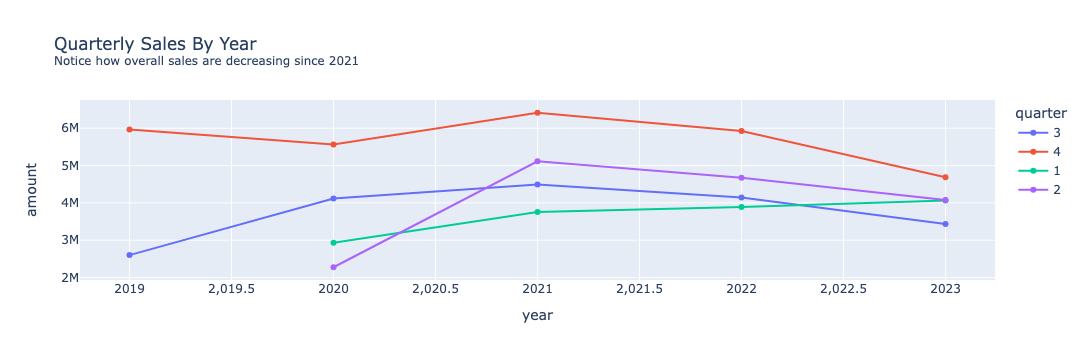

In [16]:
# Visualizing for every quarter
fig = px.line(transaction_quarter, x='year', y='amount', color='quarter', 
              title="Quarterly Sales By Year <br><sup>Notice how overall sales are decreasing since 2021</sup>", 
              markers=True)

fig.show()

/Users/matticii/anaconda3/lib/python3.11/site-packages/_plotly_utils/basevalidators.py:106: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



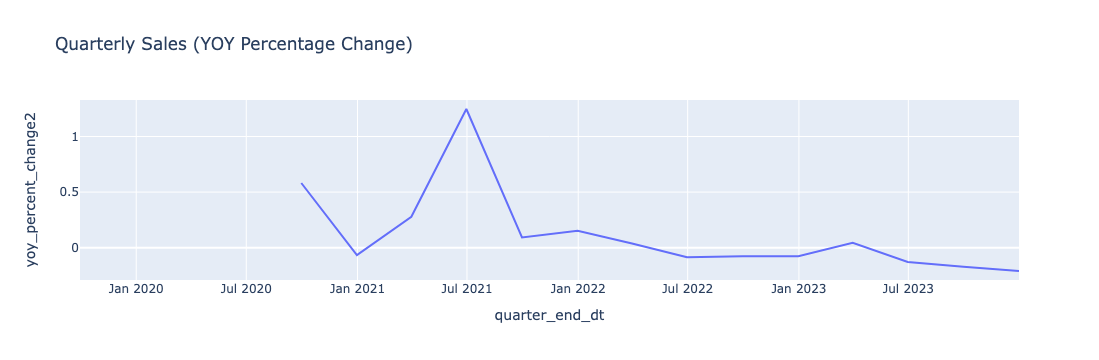

In [17]:
px.line(transaction_quarter, y = 'yoy_percent_change2', title="Quarterly Sales (YOY Percentage Change)")

In [18]:
merged = pd.concat([overall_yoy_growth, transaction_quarter], axis=1)
data = reported_numbers.drop(['entity', 'metric'], axis=1)
data['period_end_dt'] = pd.to_datetime(data['period_end_dt'])
data['quarter'] = data['period_end_dt'].dt.quarter
data.set_index('period_end_dt', inplace=True)
data['sales_yoy1'] = merged['yoy_percent_change']
data['sales_yoy2'] = merged['yoy_percent_change2']

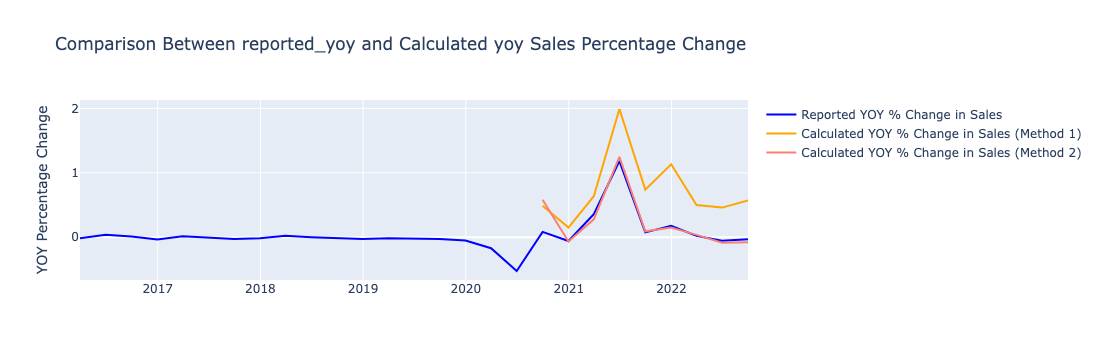

In [19]:
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=data.index, 
    y=data['reported_yoy'],
    mode='lines',
    name='Reported YOY % Change in Sales',
    line=dict(color='blue')
))


fig.add_trace(go.Scatter(
    x=data.index, 
    y=data['sales_yoy1'],
    mode='lines',
    name='Calculated YOY % Change in Sales (Method 1)',
    line=dict(color='orange')
))

#Adding the result
fig.add_trace(go.Scatter(
    x=data.index, 
    y=data['sales_yoy2'],
    mode='lines',
    name='Calculated YOY % Change in Sales (Method 2)',
    line=dict(color='salmon')
))

fig.update_layout(
    title='Comparison Between reported_yoy and Calculated yoy Sales Percentage Change',
    yaxis=dict(title='YOY Percentage Change'),
)

# Step 7: Show the plot
fig.show()

In [20]:
# Calculate the correlation (extremely high)
print('correlation, method1:', data['reported_yoy'].corr(data['sales_yoy1']))
print('correlation, method2:', data['reported_yoy'].corr(data['sales_yoy2']))

correlation, method1: 0.9117256629117568
correlation, method2: 0.9148818973123028


### Observations:
- There is seasonality in monthly (and quarterly) sales. Oct seems to be the month with highest sales.
- Since 2021, all quarters except Q1 experience a decrease in sales.
- From the two method of calculating YOY % Change in Sales, the second method is more similar to the real reported value. It also has better correlation, so we will use method two from this point on

In [21]:
# Trivial model, calculating simple average
quarterly_average = data.groupby('quarter').mean()

In [22]:
quarterly_average

reported_yoy  sales_yoy1  sales_yoy2
quarter                                      
1            0.031571    0.568194    0.157915
2            0.088857    1.225683    0.580416
3            0.010857    0.599488    0.198898
4           -0.001667    0.641723    0.042487

## Models
We first try linear models. With the calculated yoy sales values, it acts as a really good indicator such that more complex non-linear models are not really necessary (especially given that we have 10 data points).

Later, we try SARIMA(X) models because we want to make use of more datapoints (the entire history of reported_yoy values since 2016). Given that we are working with time series data, we also want to make sure of the nature of time series data, predicting future values using past values.

## Linear Models

### Model 1 (only 1 variable)

In [23]:
# Creating Model 1
data.dropna(subset=['reported_yoy', 'sales_yoy2'], inplace=True)

# Define the predictor (X) and target (y) variables
X = data[['sales_yoy2']][1:]
y = data['reported_yoy'][1:]

import statsmodels.api as sm
X = sm.add_constant(X)

# Fit the model using OLS
ols_model = sm.OLS(y, X).fit()

print(ols_model.summary())

y_pred = ols_model.predict(X)
mse = mean_squared_error(y, y_pred)
print('MSE:', mse)

                            OLS Regression Results                            
Dep. Variable:           reported_yoy   R-squared:                       0.993
Model:                            OLS   Adj. R-squared:                  0.991
Method:                 Least Squares   F-statistic:                     807.5
Date:                Wed, 30 Oct 2024   Prob (F-statistic):           1.26e-07
Time:                        21:40:38   Log-Likelihood:                 15.791
No. Observations:                   8   AIC:                            -27.58
Df Residuals:                       6   BIC:                            -27.42
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0232      0.015      1.527      0.1

/Users/matticii/anaconda3/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1806: UserWarning:

kurtosistest only valid for n>=20 ... continuing anyway, n=8



In [30]:
#testing accuracy on unseen data
# Define the predictor (X) and target (y) variables
X = data[['sales_yoy2']][1:8]
y = data['reported_yoy'][1:8]

import statsmodels.api as sm
X = sm.add_constant(X)

# Fit the model using OLS
ols_model = sm.OLS(y, X).fit()

data_with_const = sm.add_constant(data[['sales_yoy2']][8:], has_constant='add')
y_pred = ols_model.predict(data_with_const)
mse = mean_squared_error(data['reported_yoy'][8:], y_pred)
mse

0.0004815475264009832

Predicts really well even for unseen data (but that again, we are just using sample 2 to test, take it with a pinch of salt)

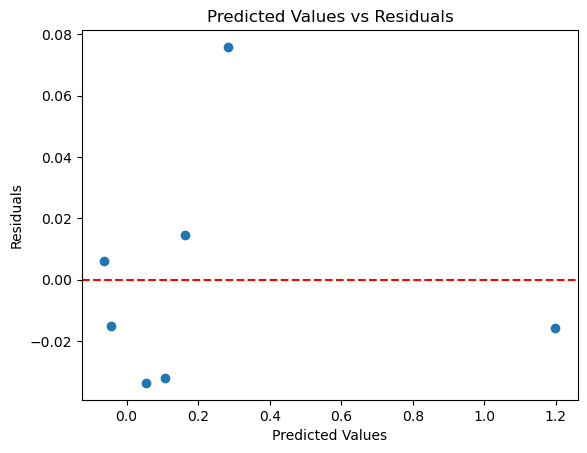

In [31]:
#Checking assumptions
# Get residuals
residuals = ols_model.resid

# Plot predicted values vs residuals
plt.scatter(ols_model.fittedvalues, residuals)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Predicted Values vs Residuals")
plt.show()

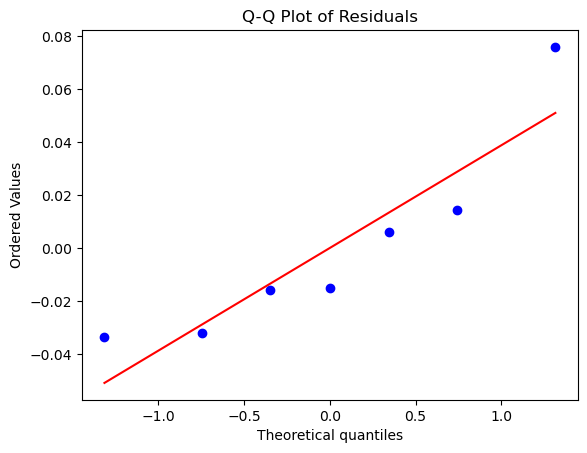

In [32]:
import scipy.stats as stats

# Q-Q plot for residuals
stats.probplot(residuals, dist="norm", plot=plt)
plt.title("Q-Q Plot of Residuals")
plt.show()

In [33]:
from statsmodels.stats.diagnostic import het_breuschpagan

# Perform Breusch-Pagan test
bp_test = het_breuschpagan(residuals, ols_model.model.exog)
print(f"Breusch-Pagan test p-value: {bp_test[1]}")

Breusch-Pagan test p-value: 0.9916153057378962


We checked the residuals for independence, normality and homoscedacity, and the model passes all three assumption tests.

We note the high level of disturbance during covid period. We would want to encapsulate this information in some way, ie how covid may have impacted consumer behaviors.

1. A binary covid variable: 0 for non-covid years, 1 for covid years

1. CPI: 
CPI measures the average change over time in the prices paid by consumers for a basket of goods and services. It is mainly used to account for growth rate.

2. Consumer Confidence Index (CCI): CCI measures the optimism or pessimism of consumers regarding their expected financial situations and the overall state of the economy.

3. Consumer Sentiment Index (by UMICH): The UMich Consumer Sentiment Index focuses heavily on personal financial situations and individual spending attitudes. Since party equipment sales are tied closely to discretionary spending, understanding personal financial confidence and willingness to make non-essential purchases is crucial.

The difference between CCI and Consumer Sentiment Index is that the latter capture the consumer’s willingness to spend on non-essential goods, while the CCI could add context regarding general economic conditions and employment stability, which indirectly influence consumer spending habits. In our case, we preliminary suspect that Consumer Sentiment Index would be a better indicator.

### Linear Model 2 (with other variables)

In [34]:
# Add exogenous Factor
# Next, we experiment with adding a dummy for covid and post_covid
data['covid'] = [1]*4 + [0]*5

# CPI quarterly growth rate compared to same period of previous year from OECD
# https://data-explorer.oecd.org/
CPI = [1.22238600000000000, 1.23948800000000000, 1.89851400000000000, 4.84894500000000000,
       5.33569300000000000, 6.68910600000000000,7.96670700000000000, 8.63561200000000000, 
       8.32947500000000000, 7.10167200000000000, 5.80477000000000000, 3.97429200000000000,
       3.51429000000000000, 3.24340100000000000]

# CCI (long term average of 100)
CCI = [98.45784, 98.8136033333333, 99.354301, 100.2623, 100.132053333333, 99.52986, 98.4674033333333, 97.18221, 
       96.6233633333333, 96.95303, 97.72194, 98.30454, 98.45501, 98.39436]

# Consumer barometer data from OECD, corresponds to the monthly growth rate of the normalised consumer confidence indicator
#cci_norm = [0.06, 0.01, 0.11, 0.02, -0.33, -0.06, -0.30, -0.25, 0.23, 0.03, 0.06, 0.06, 0.10, 0.05]

consumer_sent = pd.read_csv('consumer sentiment.csv', skiprows=1)
consumer_sent.drop('Unnamed: 3', axis=1, inplace=True)
consumer_sent['yoy_change'] = consumer_sent['Index'].pct_change(periods=4)
consumer_sent = consumer_sent[6:]
#consumer_sent = pd.read_csv('consumer_sent.csv', skiprows=1)[2:]

In [35]:
data['CPI'], data['CCI'] = CPI[:9], CCI[:9]
data['consumer_sentiment'] = consumer_sent['yoy_change'][:9].tolist()
# Creating a new column with lagged values of 'sales_yoy2'
data['sales_yoy_lag1'] = data['sales_yoy2'].shift(1)

In [36]:
# Calculating correlation.
# Notice how correlation between reported yoy and consumer sentiment is high
data.corr()

reported_yoy   quarter  sales_yoy1  sales_yoy2     covid  \
reported_yoy            1.000000 -0.277927    0.911726    0.914882  0.474379   
quarter                -0.277927  1.000000   -0.098167   -0.190737 -0.046625   
sales_yoy1              0.911726 -0.098167    1.000000    0.811303  0.134445   
sales_yoy2              0.914882 -0.190737    0.811303    1.000000  0.591228   
covid                   0.474379 -0.046625    0.134445    0.591228  1.000000   
CPI                    -0.160066 -0.173399    0.127017   -0.327192 -0.882040   
CCI                     0.602932  0.025660    0.569795    0.557257  0.354648   
consumer_sentiment      0.832871  0.036251    0.826929    0.772252  0.327915   
sales_yoy_lag1         -0.062270  0.350240   -0.032843   -0.008787 -0.027930   

                         CPI       CCI  consumer_sentiment  sales_yoy_lag1  
reported_yoy       -0.160066  0.602932            0.832871       -0.062270  
quarter            -0.173399  0.025660            0.036251        0.350240  
sales_yoy1          0.127017  0.569795            0.826929       -0.032843  
sales_yoy2         -0.327192  0.557257            0.772252       -0.008787  
covid              -0.882040  0.354648            0.327915       -0.027930  
CPI                 1.000000 -0.433457           -0.227231       -0.284523  
CCI                -0.433457  1.000000            0.836955        0.532097  
consumer_sentiment -0.227231  0.836955            1.000000        0.455605  
sales_yoy_lag1     -0.284523  0.532097            0.455605        1.000000

In [37]:
# Define the predictor (X) and target (y) variables
X = data[['sales_yoy2', 'covid', 'CPI', 'CCI', 'consumer_sentiment']][1:]
y = data['reported_yoy'][1:]

import statsmodels.api as sm
X = sm.add_constant(X)

# Fit the model using OLS
ols_model2 = sm.OLS(y, X).fit()

print(ols_model2.summary())

# Prediction
y_pred = ols_model2.predict(X)
mse = mean_squared_error(y, y_pred)
print('MSE:', mse)

                            OLS Regression Results                            
Dep. Variable:           reported_yoy   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                     7437.
Date:                Wed, 30 Oct 2024   Prob (F-statistic):           0.000134
Time:                        21:49:30   Log-Likelihood:                 35.475
No. Observations:                   8   AIC:                            -58.95
Df Residuals:                       2   BIC:                            -58.47
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  7.5764      0

/Users/matticii/anaconda3/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1806: UserWarning:

kurtosistest only valid for n>=20 ... continuing anyway, n=8



In [38]:
#testing accuracy on unseen data
# Define the predictor (X) and target (y) variables
X = data[['sales_yoy2', 'covid', 'CPI', 'CCI', 'consumer_sentiment']][1:8]
y = data['reported_yoy'][1:8]

import statsmodels.api as sm
X = sm.add_constant(X)

# Fit the model using OLS
ols_model2 = sm.OLS(y, X).fit()

data_with_const = sm.add_constant(data[['sales_yoy2', 'covid', 'CPI', 'CCI', 'consumer_sentiment']][8:], has_constant='add')
y_pred = ols_model2.predict(data_with_const)
mse = mean_squared_error(data['reported_yoy'][8:], y_pred)
mse


0.000652673396037436

The R^2 value better, the mse performance on unseen data is slightly worse than the previous simpler model!
(that said, we only have one test data).

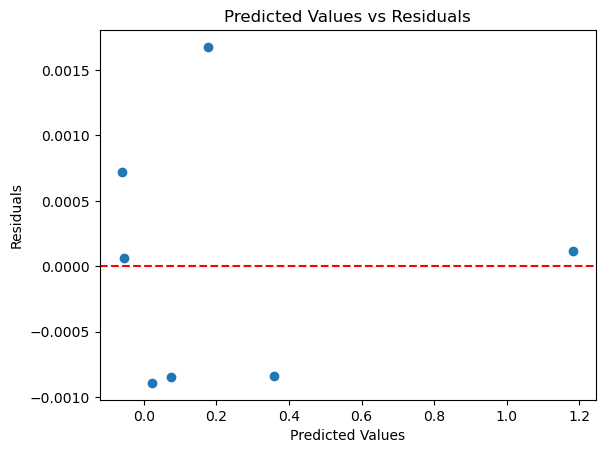

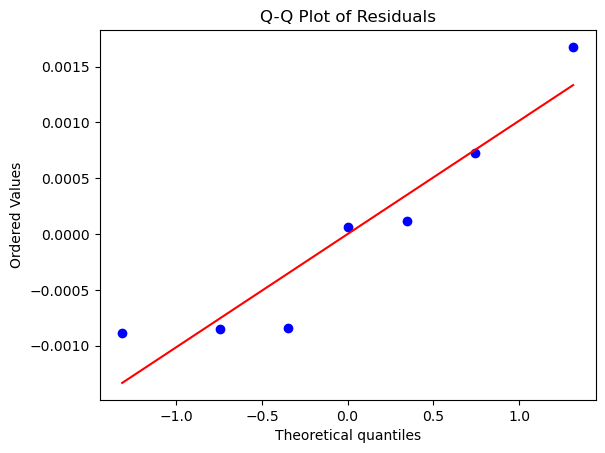

Breusch-Pagan test p-value: 0.4616456847709014


In [39]:
# Checking assumptions
# Get residuals
residuals = ols_model2.resid

# Plot predicted values vs residuals
plt.scatter(ols_model2.fittedvalues, residuals)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Predicted Values vs Residuals")
plt.show()

# Q-Q plot for residuals
stats.probplot(residuals, dist="norm", plot=plt)
plt.title("Q-Q Plot of Residuals")
plt.show()

# Perform Breusch-Pagan test
bp_test = het_breuschpagan(residuals, ols_model2.model.exog)
print(f"Breusch-Pagan test p-value: {bp_test[1]}")

Once again, it passes all assumption checks.

### Model 3: trying to remove some features

In [40]:
# Define the predictor (X) and target (y) variables
X = data[['sales_yoy2', 'covid', 'CPI', 'consumer_sentiment']][1:]
y = data['reported_yoy'][1:]

import statsmodels.api as sm
X = sm.add_constant(X)

# Fit the model using OLS
ols_model3 = sm.OLS(y, X).fit()

ols_model3.summary()

/Users/matticii/anaconda3/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1806: UserWarning:

kurtosistest only valid for n>=20 ... continuing anyway, n=8



<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           reported_yoy   R-squared:                       0.997
Model:                            OLS   Adj. R-squared:                  0.994
Method:                 Least Squares   F-statistic:                     271.0
Date:                Wed, 30 Oct 2024   Prob (F-statistic):           0.000362
Time:                        21:53:17   Log-Likelihood:                 19.722
No. Observations:                   8   AIC:                            -29.44
Df Residuals:                       3   BIC:                            -29.05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.1405      0.114      1.238      0.304      -0.221       0.502
sales_yoy2             1.2072      0.158      7.621      0.005       0.703       1.711
covid                 -0.1837      0.141     -1.300      0.285      -0.633       0.266
CPI                   -0.0350      0.023     -1.522      0.225      -0.108       0.038
consumer_sentiment    -0.6868      0.355     -1.932      0.149      -1.818       0.445
==============================================================================
Omnibus:                        1.366   Durbin-Watson:                   1.722
Prob(Omnibus):                  0.505   Jarque-Bera (JB):                0.344
Skew:                           0.500   Prob(JB):                        0.842
Kurtosis:                       2.817   Cond. No.                         221.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [41]:
y_pred = ols_model3.predict(X)
mse = mean_squared_error(y, y_pred)
mse

0.0004228751828857613

In [43]:
# Using anova to see if we should remove any 
from statsmodels.stats.anova import anova_lm
anova_results = anova_lm(ols_model, ols_model2)
print(anova_results)

   df_resid       ssr  df_diff   ss_diff           F   Pr(>F)
0       5.0  0.008644      0.0       NaN         NaN      NaN
1       1.0  0.000006      4.0  0.008639  387.501258  0.03808


Comparing the various models using anova, we notice that there is sufficient evidence to suggest that the more complex model (model2) is better. However, we would like to use both models for comparison, as the p-value is very close to 0.05 and we would like to consider using a mixture of both for prediction.

### Final Models

In [44]:
# Define the predictor (X) and target (y) variables
X = data[['sales_yoy2']][1:]
y = data['reported_yoy'][1:]

import statsmodels.api as sm
X = sm.add_constant(X)

# Fit the model using OLS
ols_model = sm.OLS(y, X).fit()

ols_model.summary()

/Users/matticii/anaconda3/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1806: UserWarning:

kurtosistest only valid for n>=20 ... continuing anyway, n=8



<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           reported_yoy   R-squared:                       0.993
Model:                            OLS   Adj. R-squared:                  0.991
Method:                 Least Squares   F-statistic:                     807.5
Date:                Wed, 30 Oct 2024   Prob (F-statistic):           1.26e-07
Time:                        21:59:21   Log-Likelihood:                 15.791
No. Observations:                   8   AIC:                            -27.58
Df Residuals:                       6   BIC:                            -27.42
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0232      0.015      1.527      0.178      -0.014       0.060
sales_yoy2     0.9410      0.033     28.416      0.000       0.860       1.022
==============================================================================
Omnibus:                        4.276   Durbin-Watson:                   2.544
Prob(Omnibus):                  0.118   Jarque-Bera (JB):                1.318
Skew:                           0.988   Prob(JB):                        0.517
Kurtosis:                       3.225   Cond. No.                         2.53
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

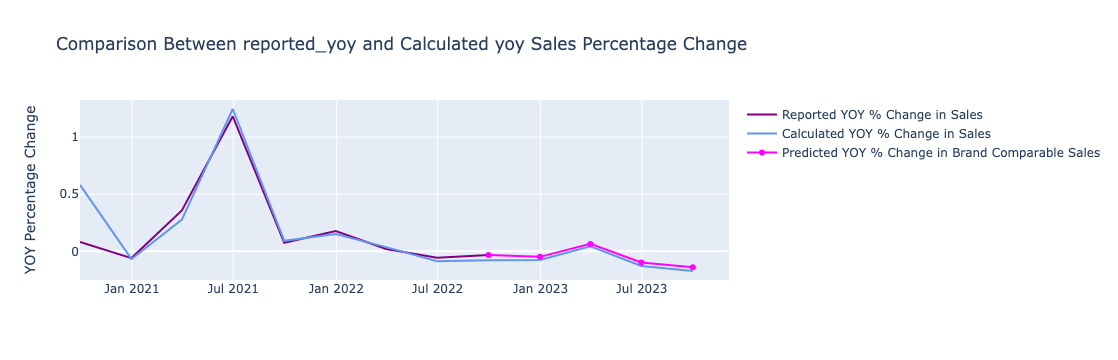

Prediction:             reported_yoy
2022-12-31     -0.048289
2023-03-31      0.065358
2023-06-30     -0.096752
2023-09-30     -0.138694


In [45]:
dates = pd.to_datetime(['2022-12-31', '2023-03-31', '2023-06-30', '2023-09-30'])

data_pred = pd.DataFrame({
    'sales_yoy2': transaction_quarter.loc['2022-12-31':'2023-09-30']['yoy_percent_change2'].tolist(),
    'covid': [0] *4,
    'CPI': CPI[9:13], 
    'CCI': CCI[9:13],
    'consumer_sentiment': consumer_sent['yoy_change'][9:13].tolist()
}, index=dates)

data_pred_wconst = sm.add_constant(data_pred[['sales_yoy2']])
new_pred = ols_model.predict(data_pred_wconst)
data_pred1 = data_pred.copy()
data_pred1['reported_yoy'] = new_pred
data_pred1 = pd.concat([data, data_pred1])

fig = go.Figure()

fig.add_trace(go.Scatter(
    x=data.index, 
    y=data['reported_yoy'],
    mode='lines',
    name='Reported YOY % Change in Sales',
    line=dict(color='purple')
))


fig.add_trace(go.Scatter(
    x=data_pred1.index, 
    y=data_pred1['sales_yoy2'],
    mode='lines',
    name='Calculated YOY % Change in Sales',
    line=dict(color='cornflowerblue')
))

#Adding the result
fig.add_trace(go.Scatter(
    x=data_pred1.loc['2022-09-30':'2023-09-30'].index, 
    y=data_pred1.loc['2022-09-30':'2023-09-30']['reported_yoy'],
    mode='lines+markers',
    name='Predicted YOY % Change in Brand Comparable Sales',
    line=dict(color='magenta')
))

fig.update_layout(
    title='Comparison Between reported_yoy and Calculated yoy Sales Percentage Change',
    yaxis=dict(title='YOY Percentage Change'),
)

fig.show()

print('Prediction:', data_pred1[-4:][['reported_yoy']])

In [46]:
# Final model 2

# Define the predictor (X) and target (y) variables
X = data[['sales_yoy2', 'covid', 'CPI', 'CCI', 'consumer_sentiment']][1:]
y = data['reported_yoy'][1:]

import statsmodels.api as sm
X = sm.add_constant(X)

# Fit the model using OLS
ols_model2 = sm.OLS(y, X).fit()

ols_model2.summary()


/Users/matticii/anaconda3/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1806: UserWarning:

kurtosistest only valid for n>=20 ... continuing anyway, n=8



<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           reported_yoy   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                     7437.
Date:                Wed, 30 Oct 2024   Prob (F-statistic):           0.000134
Time:                        22:00:53   Log-Likelihood:                 35.475
No. Observations:                   8   AIC:                            -58.95
Df Residuals:                       2   BIC:                            -58.47
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  7.5764      0.741     10.219      0.009       4.386      10.767
sales_yoy2             1.5522      0.044     35.465      0.001       1.364       1.740
covid                 -0.5746      0.046    -12.533      0.006      -0.772      -0.377
CPI                   -0.1063      0.008    -13.087      0.006      -0.141      -0.071
CCI                   -0.0707      0.007    -10.033      0.010      -0.101      -0.040
consumer_sentiment    -0.9266      0.065    -14.188      0.005      -1.208      -0.646
==============================================================================
Omnibus:                        1.072   Durbin-Watson:                   2.777
Prob(Omnibus):                  0.585   Jarque-Bera (JB):                0.714
Skew:                          -0.618   Prob(JB):                        0.700
Kurtosis:                       2.216   Cond. No.                     3.63e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.63e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

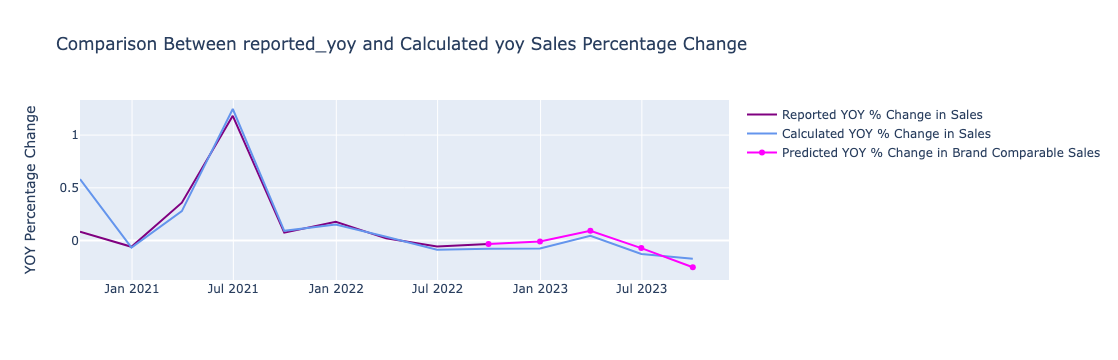

Prediction:             reported_yoy
2022-12-31     -0.008834
2023-03-31      0.092950
2023-06-30     -0.071154
2023-09-30     -0.252908


In [47]:
data_pred_wconst = sm.add_constant(data_pred[['sales_yoy2', 'covid', 'CPI', 'CCI', 'consumer_sentiment']], has_constant='add')
new_pred = ols_model2.predict(data_pred_wconst)
data_pred1 = data_pred.copy()
data_pred1['reported_yoy'] = new_pred
data_pred1 = pd.concat([data, data_pred1])

fig = go.Figure()

fig.add_trace(go.Scatter(
    x=data.index, 
    y=data['reported_yoy'],
    mode='lines',
    name='Reported YOY % Change in Sales',
    line=dict(color='purple')
))


fig.add_trace(go.Scatter(
    x=data_pred1.index, 
    y=data_pred1['sales_yoy2'],
    mode='lines',
    name='Calculated YOY % Change in Sales',
    line=dict(color='cornflowerblue')
))

#Adding the result
fig.add_trace(go.Scatter(
    x=data_pred1.loc['2022-09-30':'2023-09-30'].index, 
    y=data_pred1.loc['2022-09-30':'2023-09-30']['reported_yoy'],
    mode='lines+markers',
    name='Predicted YOY % Change in Brand Comparable Sales',
    line=dict(color='magenta')
))

fig.update_layout(
    title='Comparison Between reported_yoy and Calculated yoy Sales Percentage Change',
    yaxis=dict(title='YOY Percentage Change'),
)

fig.show()

print('Prediction:', data_pred1[-4:][['reported_yoy']])

## SARIMA Model

When using the previous model, we are essentially ignoring most of the data precovid due to the absence of sales data. However, we may want to make use of those data as well. Furthermore, we also want to make use of the special character of time series data and use previous values to predict its future values (while taking into account the errors involve).

Hence, we may consider using a SARIMA(X) model, using the autoregressive nature of the data to predict future data. As it regresses against itself, we could also predict future trends in the absence of future sales data. (Answers second question).

Best models:

SARIMA models:
Overall, having a differenced term reduces the AIC, but due to the impact of covid years, it may affect the actual prediction.
1. If we want to include a differenced term (assuming original data is not stationary), we use SARIMA (1, 1, 0)x(1, 0, 1, 4).
2. Without a differenced term, SARIMA (1, 0, 0)x(1, 0, 1, 4) may be better.

SARIMAX models: It generally performs better than pure SARIMA models
1. Best model given by (1, 0, 0)x(1, 0, 1, 4) with just covid exog (binary) with AIC = 0.14.
2. Model fitting both covid and consumer sentiment AIC = 0.28, similar error with 
 



Figure(640x480)
Figure(640x480)


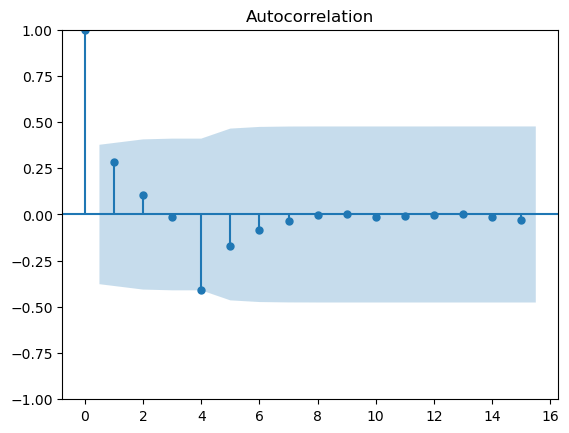

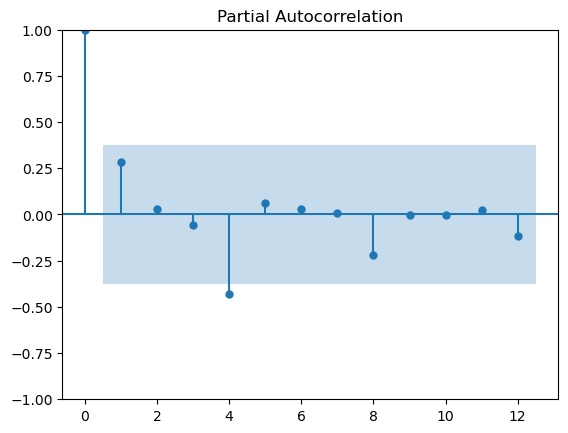

In [48]:
# Understanding ACF and PACF of the trends
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

data = reported_numbers.drop(['entity', 'metric'], axis=1)
data['period_end_dt'] = pd.to_datetime(data['period_end_dt'])
data.set_index('period_end_dt', inplace=True)

# Seems like Q=1
print(plot_acf(data.reported_yoy))

# Seems like P=1, maybe p=1?
print(plot_pacf(data.reported_yoy, lags=12))

In [49]:
# Testing stationarity using adfuller, one of the assumptions of ARIMA
from statsmodels.tsa.stattools import adfuller

def adfuller_test(trends):
    result=adfuller(trends)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")

adfuller_test(data.reported_yoy)

ADF Test Statistic : -2.6753005883385534
p-value : 0.07841073115438939
#Lags Used : 8
Number of Observations Used : 18
weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 


We want to investigate how the different stores are doing by checking the change in sales postcovid compared to precovid, to understand whether there has been a change in trajectory over time.

In [50]:
# Try to take a difference and doing adfuller again, since the adfuller test shows nonstationarity.

differenced_data = data.reported_yoy.diff().dropna()
adfuller_test(differenced_data)



ADF Test Statistic : -2.9067784675828463
p-value : 0.04456541299809761
#Lags Used : 9
Number of Observations Used : 16
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary


By taking a difference, we definitely see a decrease in p-value, but later, we will decide whether to use difference 1 or no difference based on other expectations.

This is because the covid data essentially skewed the current dataset (almost in an upward trend due to the spending patterns that happened in 2021 after lockdown). Furthermore, by not taking a difference, our p-value is just 0.078, which is not too far away from 0.05. We may therefore want to model it as stationary.

In [51]:
# Using autoarima to check what is the best model to use.
# We are only using it as reference. AIC is just an indicator and not everything. 
# We want to integrate the AIC here with our observations from ACF and PACF.

from pmdarima import auto_arima
auto_arima(data, trace=True, seasonal= True, max_p=4, max_q=4, m=4, suppress_warnings=True, trend = 'ct')

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[4] intercept   : AIC=9.838, Time=0.48 sec
 ARIMA(0,0,0)(0,0,0)[4] intercept   : AIC=9.354, Time=0.03 sec
 ARIMA(1,0,0)(1,0,0)[4] intercept   : AIC=5.706, Time=0.20 sec
 ARIMA(0,0,1)(0,0,1)[4] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(0,0,0)(0,0,0)[4]             : AIC=9.354, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[4] intercept   : AIC=9.662, Time=0.02 sec
 ARIMA(1,0,0)(2,0,0)[4] intercept   : AIC=4.800, Time=0.32 sec
 ARIMA(1,0,0)(2,0,1)[4] intercept   : AIC=4.317, Time=0.13 sec
 ARIMA(1,0,0)(1,0,1)[4] intercept   : AIC=3.856, Time=0.12 sec
 ARIMA(1,0,0)(0,0,1)[4] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(1,0,0)(1,0,2)[4] intercept   : AIC=inf, Time=0.36 sec
 ARIMA(1,0,0)(0,0,2)[4] intercept   : AIC=3.799, Time=0.12 sec
 ARIMA(0,0,0)(0,0,2)[4] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(2,0,0)(0,0,2)[4] intercept   : AIC=5.728, Time=0.14 sec
 ARIMA(1,0,1)(0,0,2)[4] intercept   : AIC=5.802, Time=0.18 sec
 ARIMA(0,0,1)(0,0,2)

ARIMA(order=(0, 0, 1), scoring_args={}, seasonal_order=(0, 0, 2, 4),
      suppress_warnings=True, trend='ct')

### Sarima model 1

/Users/matticii/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency Q-DEC will be used.

/Users/matticii/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency Q-DEC will be used.

/Users/matticii/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning:

Non-stationary starting seasonal autoregressive Using zeros as starting parameters.

/Users/matticii/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning:

Non-invertible starting seasonal moving average Using zeros as starting parameters.

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.35631D-01    |proj g|=  3.38063D-01

At iterate    5    f= -1.74308D-01    |proj g|=  4.92334D-02

At iterate   10    f= -1.78474D-01    |proj g|=  6.65805D-02

At iterate   15    f= -1.84125D-01    |proj g|=  7.96376D-02

At iterate   20    f= -1.88323D-01    |proj g|=  7.21914D-02

At iterate   25    f= -1.90338D-01    |proj g|=  4.72724D-02

At iterate   30    f= -1.90596D-01    |proj g|=  1.01439D-02

At iterate   35    f= -1.90643D-01    |proj g|=  1.06565D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

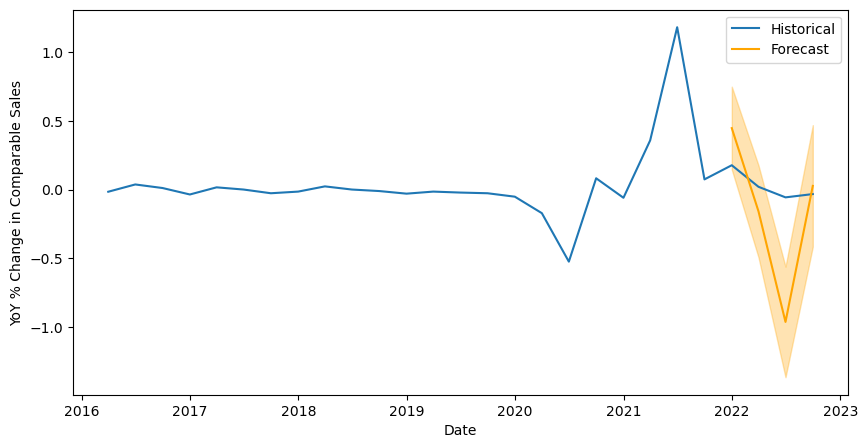

In [58]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Define the number of steps to hold out as pseudo "test set"
holdout_steps = 4

# Split the data into training and testing sets
train = data['reported_yoy'][:-holdout_steps]
test = data['reported_yoy'][-holdout_steps:]

# Define SARIMA model parameters
arima_order = (1, 1, 0)      
seasonal_order = (1, 0, 1, 4)

# Fit SARIMA model on the training set
sarima_model = SARIMAX(train, order=arima_order, seasonal_order=seasonal_order)
sarima_result = sarima_model.fit()

# Forecast for the length of the test set
forecast = sarima_result.get_forecast(steps=holdout_steps)
forecast_mean = forecast.predicted_mean
forecast_ci = forecast.conf_int()

# Calculate accuracy metrics
mse = mean_squared_error(test, forecast_mean)
mae = mean_absolute_error(test, forecast_mean)
mape = np.mean(np.abs((test - forecast_mean) / test)) * 100  # Mean Absolute Percentage Error

print(f'Mean Squared Error (MSE): {mse}')
print(f'Mean Absolute Error (MAE): {mae}')
print(f'Mean Absolute Percentage Error (MAPE): {mape:.2f}%')
print('AIC:', sarima_result.aic)

# Plot historical data, forecast, and confidence intervals
plt.figure(figsize=(10, 5))
plt.plot(data['reported_yoy'], label='Historical')
plt.plot(forecast_mean.index, forecast_mean, color='orange', label='Forecast')
plt.fill_between(forecast_ci.index, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1], color='orange', alpha=0.3)
plt.xlabel('Date')
plt.ylabel('YoY % Change in Comparable Sales')
plt.legend()
plt.show()

Figure(640x480)
Figure(640x480)


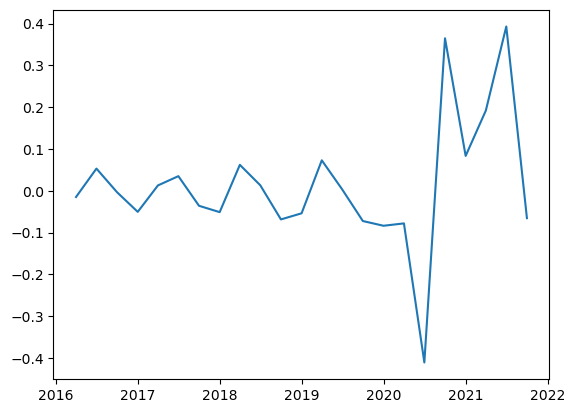

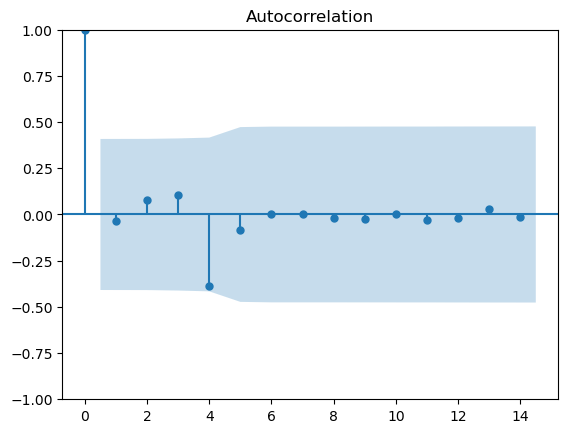

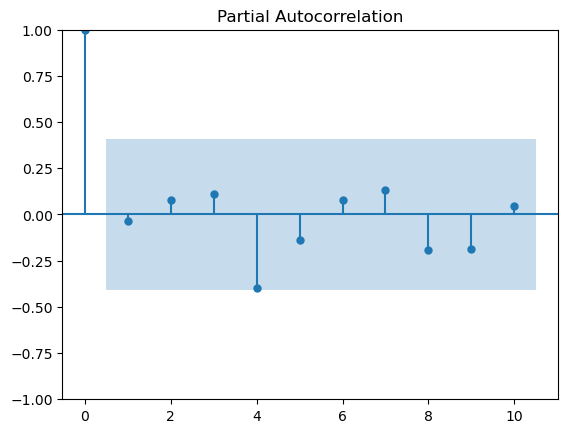

In [53]:
# Evaluation: we observe that residuals are random and resembles white noise.
print(plt.plot(sarima_result.resid))
print(plot_acf(sarima_result.resid))
print(plot_pacf(sarima_result.resid, lags=10))

In [54]:
# Ljungbox Diagnostic for SARIMA Model
from statsmodels.stats.diagnostic import acorr_ljungbox

ljung_box_results = acorr_ljungbox(sarima_result.resid, lags=[10], return_df=True)
print("Ljung-Box Test Results:\n", ljung_box_results)

# High p-value suggests that residuals resemble white noise.

Ljung-Box Test Results:
      lb_stat  lb_pvalue
10  5.363739   0.865594


### SARIMA Model 2

In [55]:
# Define SARIMA model parameters
arima_order2 = (1, 0, 1)      
seasonal_order2 = (1, 0, 1, 4)

# Fit SARIMA model on the training set
sarima_model2 = SARIMAX(train, order=arima_order2, seasonal_order=seasonal_order2)
sarima_result2 = sarima_model2.fit()

# Forecast for the length of the test set
forecast = sarima_result2.get_forecast(steps=4)
forecast_mean = forecast.predicted_mean
forecast_ci = forecast.conf_int()

# Calculate accuracy metrics
mse = mean_squared_error(test, forecast_mean)
mae = mean_absolute_error(test, forecast_mean)
mape = np.mean(np.abs((test - forecast_mean) / test)) * 100  # Mean Absolute Percentage Error

print(f'Mean Squared Error (MSE): {mse}')
print(f'Mean Absolute Error (MAE): {mae}')
print(f'Mean Absolute Percentage Error (MAPE): {mape:.2f}%')
print('AIC:', sarima_result2.aic)

# # Plot historical data, forecast, and confidence intervals
# plt.figure(figsize=(10, 5))
# plt.plot(data['reported_yoy'], label='Historical')
# plt.plot(forecast_mean.index, forecast_mean, color='orange', label='Forecast')
# plt.fill_between(forecast_ci.index, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1], color='orange', alpha=0.3)
# plt.xlabel('Date')
# plt.ylabel('YoY % Change in Comparable Sales')
# plt.legend()
# plt.show()

/Users/matticii/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency Q-DEC will be used.

/Users/matticii/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency Q-DEC will be used.

/Users/matticii/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning:

Non-stationary starting seasonal autoregressive Using zeros as starting parameters.

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.91254D-02    |proj g|=  7.58030D-01

At iterate    5    f= -2.56475D-01    |proj g|=  3.54744D-01

At iterate   10    f= -2.66008D-01    |proj g|=  1.55989D-01

At iterate   15    f= -2.79480D-01    |proj g|=  2.82417D-01

At iterate   20    f= -2.98069D-01    |proj g|=  3.76973D-02

At iterate   25    f= -2.98985D-01    |proj g|=  1.81618D-02

At iterate   30    f= -2.99657D-01    |proj g|=  2.19185D-02

At iterate   35    f= -2.99769D-01    |proj g|=  2.53858D-03

At iterate   40    f= -2.99782D-01    |proj g|=  2.33387D-03

At iterate   45    f= -2.99785D-01    |proj g|=  1.21351D-03

At iterate   50    f= -2.99785D-01    |proj g|=  5.18215D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

/Users/matticii/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Figure(640x480)
Figure(640x480)


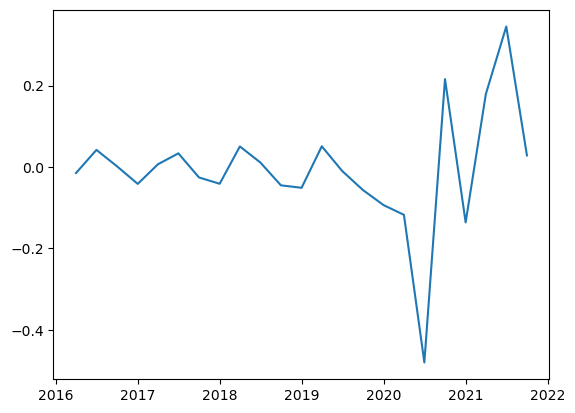

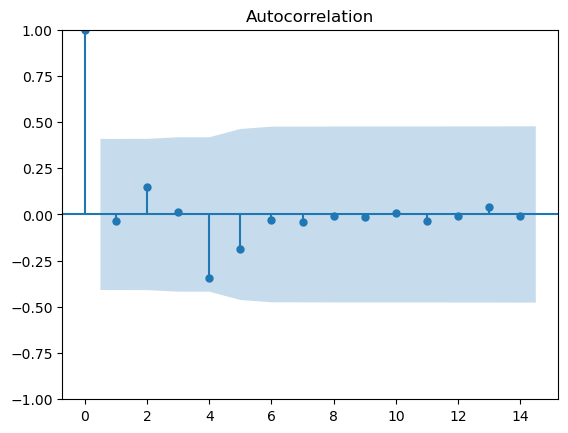

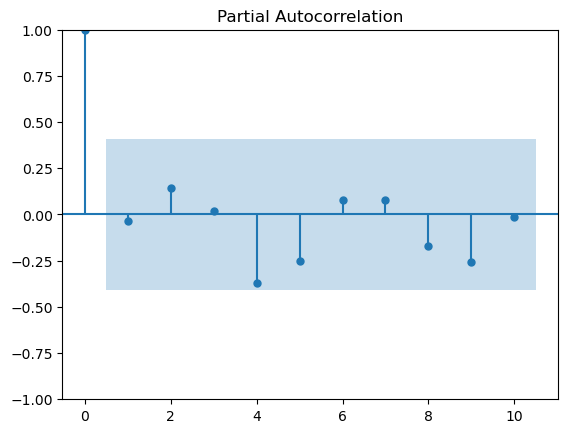

In [56]:
# Evaluation: we observe that residuals are random and resembles white noise.
print(plt.plot(sarima_result2.resid))
print(plot_acf(sarima_result2.resid))
print(plot_pacf(sarima_result2.resid, lags=10))

### Final Sarima model

/Users/matticii/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency Q-DEC will be used.

/Users/matticii/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency Q-DEC will be used.

/Users/matticii/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning:

Non-invertible starting seasonal moving average Using zeros as starting parameters.

 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
/Users/matticii/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals


 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g re

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.69845D-01    |proj g|=  3.37657D-01

At iterate    5    f=  7.99036D-02    |proj g|=  5.01953D-02

At iterate   10    f=  5.53611D-02    |proj g|=  4.69210D-02

At iterate   15    f=  5.31359D-02    |proj g|=  2.60012D-02
AIC: 10.866927781666918

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     20     63      2     0     0   4.849D-05   5.309D-02
  F =   5.3091255216054033E-002

ABNORMAL_TERMINATION_IN_LNSRCH               

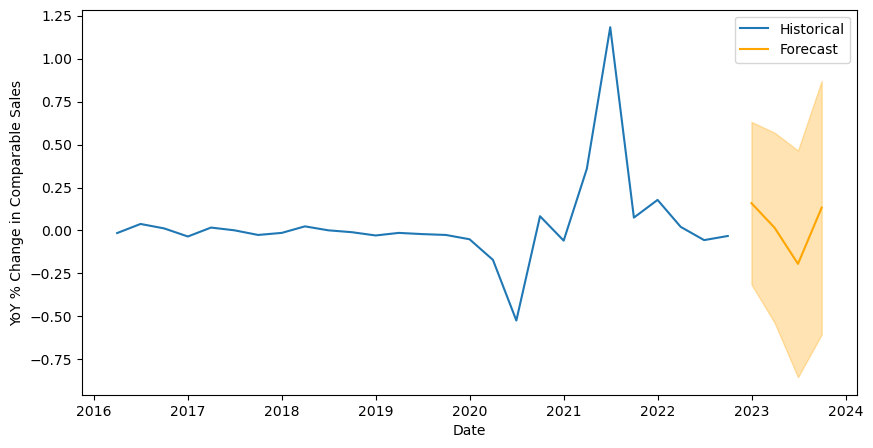

In [59]:
# FINAL SARIMA model
# We choose the first model because of better AIC and MSE, while all assumptions about residuals are checked.

arima_order = (1, 1, 0)      
seasonal_order = (1, 0, 1, 4)
sarima_model = SARIMAX(data['reported_yoy'], order=arima_order, seasonal_order=seasonal_order)
sarima_result = sarima_model.fit()

print('AIC:', sarima_result.aic)

# Forecasting for the next 4 quarters
forecast_steps = 4
forecast = sarima_result.get_forecast(steps=forecast_steps)
forecast_ci = forecast.conf_int()

# Plot results
plt.figure(figsize=(10, 5))
plt.plot(data['reported_yoy'], label='Historical')
plt.plot(forecast.predicted_mean.index, forecast.predicted_mean, color='orange', label='Forecast')
plt.fill_between(forecast_ci.index, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1], color='orange', alpha=0.3)
plt.xlabel('Date')
plt.ylabel('YoY % Change in Comparable Sales')
plt.legend()
plt.show()

In [60]:
forecast.predicted_mean

2022-12-31    0.159116
2023-03-31    0.015861
2023-06-30   -0.194256
2023-09-30    0.132959
Freq: Q-DEC, Name: predicted_mean, dtype: float64

### Model with simple covid exogenous factor

In [61]:
#try exog of the covid (simple 1/0)
data['covid'] = [0]*16 + [1]*8 + [0]*3

/Users/matticii/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency Q-DEC will be used.

/Users/matticii/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency Q-DEC will be used.

 This problem is unconstrained.
/Users/matticii/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.42439D-01    |proj g|=  2.32070D+00

At iterate    5    f= -1.65103D-01    |proj g|=  8.55965D-02

At iterate   10    f= -1.75239D-01    |proj g|=  3.57874D-01

At iterate   15    f= -1.79883D-01    |proj g|=  5.01931D-01

At iterate   20    f= -3.02320D-01    |proj g|=  7.63089D-01

At iterate   25    f= -3.15318D-01    |proj g|=  3.03571D-03

At iterate   30    f= -3.15319D-01    |proj g|=  1.56180D-03

At iterate   35    f= -3.15354D-01    |proj g|=  2.68748D-02

At iterate   40    f= -3.15485D-01    |proj g|=  8.03940D-03

At iterate   45    f= -3.15514D-01    |proj g|=  2.87413D-03

At iterate   50    f= -3.15518D-01    |proj g|=  2.80058D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

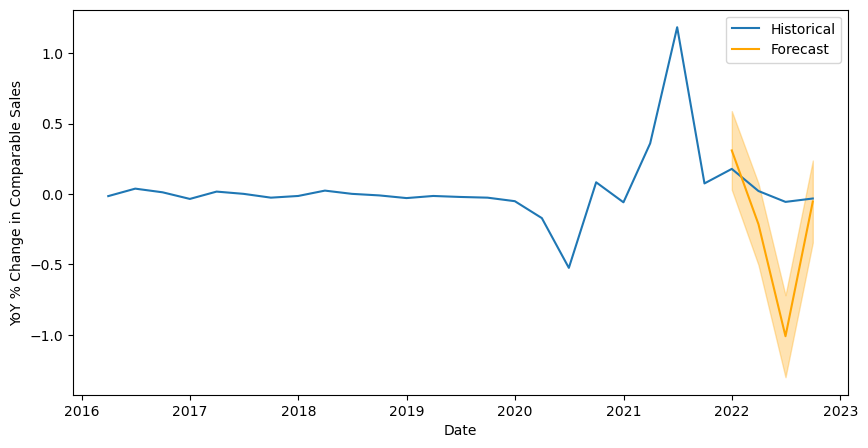

In [69]:
# Define SARIMA model parameters
arima_order2 = (1, 0, 0)      
seasonal_order2 = (1, 0, 1, 4)

# Fit SARIMA model on the training set
sarima_model2 = SARIMAX(train, order=arima_order2, seasonal_order=seasonal_order2, exog=data['covid'][:-holdout_steps])
sarima_result2 = sarima_model2.fit()

# Forecast for the length of the test set
forecast = sarima_result2.get_forecast(steps=4, exog=data['covid'][-holdout_steps:])
forecast_mean = forecast.predicted_mean
forecast_ci = forecast.conf_int()

# Calculate accuracy metrics
mse = mean_squared_error(test, forecast_mean)
mae = mean_absolute_error(test, forecast_mean)
mape = np.mean(np.abs((test - forecast_mean) / test)) * 100  

print(f'Mean Squared Error (MSE): {mse}')
print(f'Mean Absolute Error (MAE): {mae}')
print(f'Mean Absolute Percentage Error (MAPE): {mape:.2f}%')
print('AIC:', sarima_result2.aic)

# Plot historical data, forecast, and confidence intervals
plt.figure(figsize=(10, 5))
plt.plot(data['reported_yoy'], label='Historical')
plt.plot(forecast_mean.index, forecast_mean, color='orange', label='Forecast')
plt.fill_between(forecast_ci.index, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1], color='orange', alpha=0.3)
plt.xlabel('Date')
plt.ylabel('YoY % Change in Comparable Sales')
plt.legend()
plt.show()

It certainly makes error smaller even though AIC is not smaller. But we would want to check the AIC after we fit all values to ignore the noise from covid.

/Users/matticii/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency Q-DEC will be used.

/Users/matticii/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency Q-DEC will be used.

/Users/matticii/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning:

Non-invertible starting seasonal moving average Using zeros as starting parameters.

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.88333D-03    |proj g|=  3.65994D-01

At iterate    5    f= -9.94374D-02    |proj g|=  1.30643D-01

At iterate   10    f= -1.47585D-01    |proj g|=  7.91878D-02

At iterate   15    f= -1.50267D-01    |proj g|=  2.56895D-02

At iterate   20    f= -1.51391D-01    |proj g|=  2.46481D-02

At iterate   25    f= -1.51531D-01    |proj g|=  4.59558D-03

At iterate   30    f= -1.51555D-01    |proj g|=  3.97312D-03

At iterate   35    f= -1.51558D-01    |proj g|=  2.10623D-04

At iterate   40    f= -1.51558D-01    |proj g|=  3.24530D-04

At iterate   45    f= -1.51558D-01    |proj g|=  1.79283D-04

At iterate   50    f= -1.51558D-01    |proj g|=  9.65999D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

/Users/matticii/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



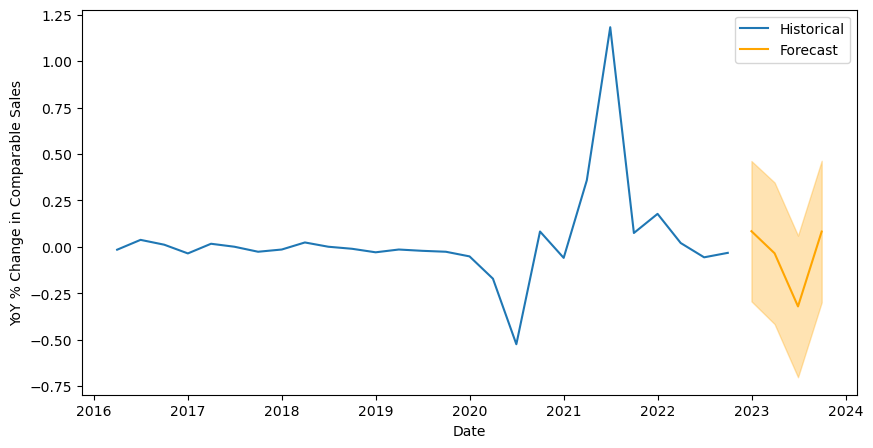

In [70]:
# Define SARIMA model parameters
arima_order2 = (1, 0, 0)      
seasonal_order2 = (1, 0, 1, 4)

# Fit SARIMA model on the training set
sarima_model2 = SARIMAX(data['reported_yoy'], order=arima_order2, seasonal_order=seasonal_order2, exog=data['covid'])
sarima_result2 = sarima_model2.fit()

# Forecast for the length of the test set
forecast = sarima_result2.get_forecast(steps=4, exog=[0]*4)
forecast_mean = forecast.predicted_mean
forecast_ci = forecast.conf_int()
print('AIC:', sarima_result2.aic)

# Plot historical data, forecast, and confidence intervals
plt.figure(figsize=(10, 5))
plt.plot(data['reported_yoy'], label='Historical')
plt.plot(forecast_mean.index, forecast_mean, color='orange', label='Forecast')
plt.fill_between(forecast_ci.index, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1], color='orange', alpha=0.3)
plt.xlabel('Date')
plt.ylabel('YoY % Change in Comparable Sales')
plt.legend()
plt.show()

In [71]:
forecast_mean

2022-12-31    0.084599
2023-03-31   -0.034350
2023-06-30   -0.320384
2023-09-30    0.082736
Freq: Q-DEC, Name: predicted_mean, dtype: float64

Figure(640x480)
Figure(640x480)


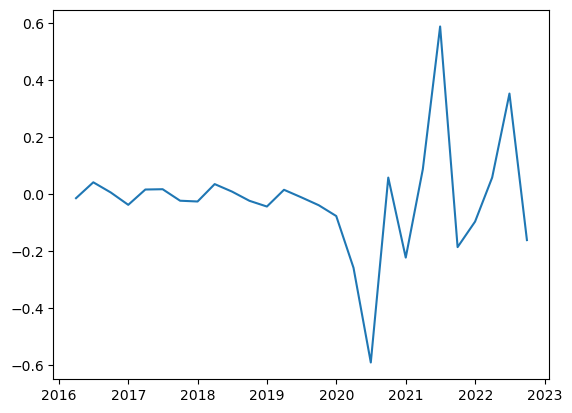

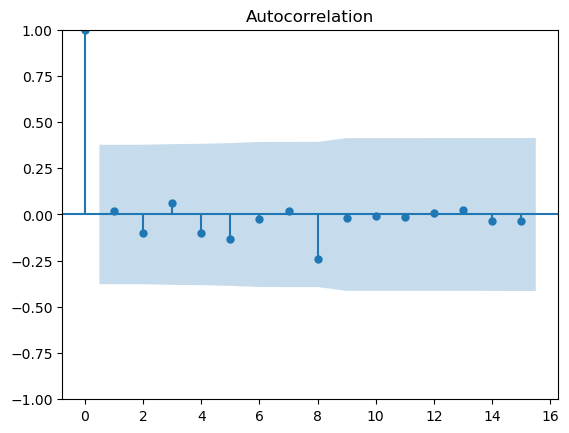

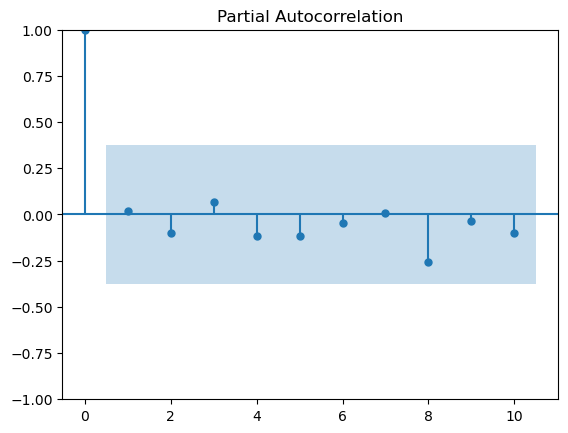

In [72]:
# Evaluation: we observe that residuals are random and resembles white noise.
print(plt.plot(sarima_result2.resid))
print(plot_acf(sarima_result2.resid))
print(plot_pacf(sarima_result2.resid, lags=10))

### Model with 2 exogs

In [73]:
consumer_sent15 = pd.read_csv('consumer sentiment 2015-.csv', skiprows=1)
consumer_sent15.drop('Unnamed: 3', axis=1, inplace=True)
consumer_sent15['yoy_change'] = consumer_sent15['Index'].pct_change(periods=4)

data['consumer_sent'] = consumer_sent15['yoy_change'][4:31].tolist()
data.head()

reported_yoy  covid  consumer_sent
period_end_dt                                    
2016-03-31           -0.015      0      -0.041885
2016-06-30            0.038      0      -0.019108
2016-09-30            0.012      0      -0.005507
2016-12-31           -0.035      0       0.020811
2017-03-31            0.017      0       0.062295

In [74]:
consumer_sent15['yoy_change'][31:35].tolist()

[-0.15879828326180268,
 0.023771790808240878,
 0.07785467128027679,
 0.24064171122994638]

/Users/matticii/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency Q-DEC will be used.

/Users/matticii/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency Q-DEC will be used.

/Users/matticii/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning:

Non-stationary starting seasonal autoregressive Using zeros as starting parameters.

 This problem is unconstrained.
/Users/matticii/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.44047D-02    |proj g|=  2.22503D+00

At iterate    5    f= -2.55772D-01    |proj g|=  5.92706D-01

At iterate   10    f= -3.76111D-01    |proj g|=  1.99187D-01

At iterate   15    f= -4.27057D-01    |proj g|=  1.50648D-01

At iterate   20    f= -4.29340D-01    |proj g|=  1.03390D-01

At iterate   25    f= -4.35583D-01    |proj g|=  1.82244D-01

At iterate   30    f= -4.36459D-01    |proj g|=  1.10578D-03

At iterate   35    f= -4.36533D-01    |proj g|=  1.02961D-02

At iterate   40    f= -4.36564D-01    |proj g|=  1.20373D-03

At iterate   45    f= -4.36570D-01    |proj g|=  5.30552D-04

At iterate   50    f= -4.36574D-01    |proj g|=  6.11923D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

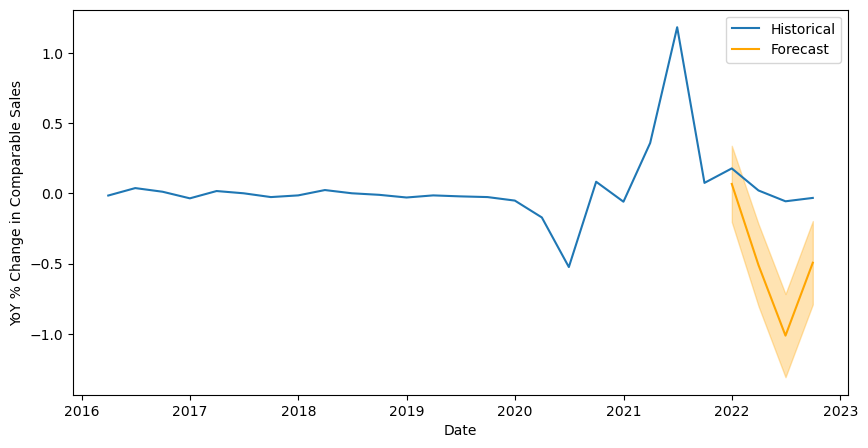

In [75]:
# Define SARIMA model parameters
arima_order2 = (1, 0, 0)      
seasonal_order2 = (1, 0, 1, 4)

# Fit SARIMA model on the training set
sarima_model2 = SARIMAX(train, order=arima_order2, seasonal_order=seasonal_order2, exog=data[['covid', 'consumer_sent']][:-holdout_steps])
sarima_result2 = sarima_model2.fit()

# Forecast for the length of the test set
forecast = sarima_result2.get_forecast(steps=4, exog=data[['covid', 'consumer_sent']][-holdout_steps:])
forecast_mean = forecast.predicted_mean
forecast_ci = forecast.conf_int()

# Calculate accuracy metrics
mse = mean_squared_error(test, forecast_mean)
mae = mean_absolute_error(test, forecast_mean)
mape = np.mean(np.abs((test - forecast_mean) / test)) * 100  

print(f'Mean Squared Error (MSE): {mse}')
print(f'Mean Absolute Error (MAE): {mae}')
print(f'Mean Absolute Percentage Error (MAPE): {mape:.2f}%')
print('AIC:', sarima_result2.aic)

# Plot historical data, forecast, and confidence intervals
plt.figure(figsize=(10, 5))
plt.plot(data['reported_yoy'], label='Historical')
plt.plot(forecast_mean.index, forecast_mean, color='orange', label='Forecast')
plt.fill_between(forecast_ci.index, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1], color='orange', alpha=0.3)
plt.xlabel('Date')
plt.ylabel('YoY % Change in Comparable Sales')
plt.legend()
plt.show()

/Users/matticii/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency Q-DEC will be used.

/Users/matticii/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency Q-DEC will be used.

/Users/matticii/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning:

Non-invertible starting seasonal moving average Using zeros as starting parameters.

 This problem is unconstrained.
/Users/matticii/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.45373D-02    |proj g|=  4.33997D-01

At iterate    5    f= -1.65421D-01    |proj g|=  5.89484D-02

At iterate   10    f= -2.07838D-01    |proj g|=  2.47958D-01

At iterate   15    f= -2.15324D-01    |proj g|=  6.81717D-02

At iterate   20    f= -2.16335D-01    |proj g|=  6.71071D-02

At iterate   25    f= -2.16938D-01    |proj g|=  5.20655D-03

At iterate   30    f= -2.16960D-01    |proj g|=  1.95743D-02

At iterate   35    f= -2.16982D-01    |proj g|=  2.57237D-03

At iterate   40    f= -2.16987D-01    |proj g|=  9.42994D-04

At iterate   45    f= -2.16987D-01    |proj g|=  1.03037D-03

At iterate   50    f= -2.16988D-01    |proj g|=  1.32005D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

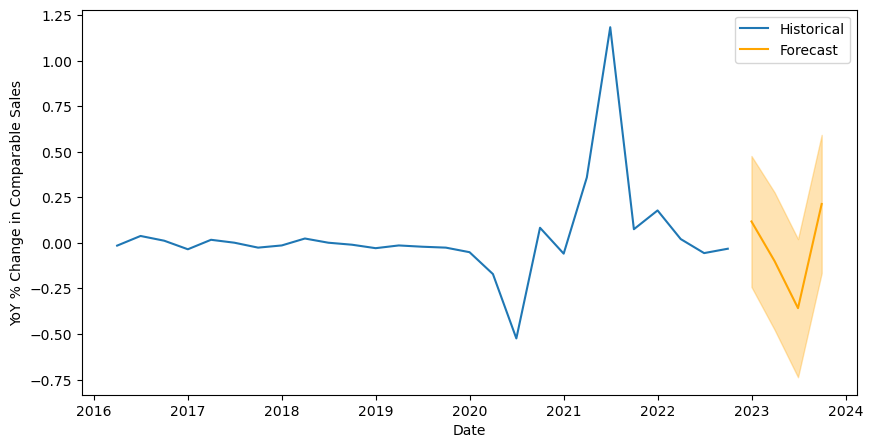

In [76]:
# Define SARIMA model parameters
arima_order2 = (1, 0, 0)      
seasonal_order2 = (1, 0, 1, 4)

# Fit SARIMA model on the training set
sarima_model2 = SARIMAX(data['reported_yoy'], order=arima_order2, seasonal_order=seasonal_order2, exog=data[['covid', 'consumer_sent']])
sarima_result2 = sarima_model2.fit()

# Forecast for the length of the test set
forecast = sarima_result2.get_forecast(steps=4, exog=[[0]*4, consumer_sent15['yoy_change'][31:35].tolist()])
forecast_mean = forecast.predicted_mean
forecast_ci = forecast.conf_int()
print('AIC:', sarima_result2.aic)

# Plot historical data, forecast, and confidence intervals
plt.figure(figsize=(10, 5))
plt.plot(data['reported_yoy'], label='Historical')
plt.plot(forecast_mean.index, forecast_mean, color='orange', label='Forecast')
plt.fill_between(forecast_ci.index, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1], color='orange', alpha=0.3)
plt.xlabel('Date')
plt.ylabel('YoY % Change in Comparable Sales')
plt.legend()
plt.show()

Figure(640x480)
Figure(640x480)


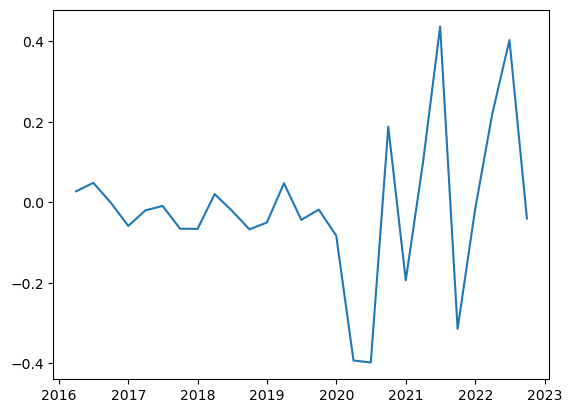

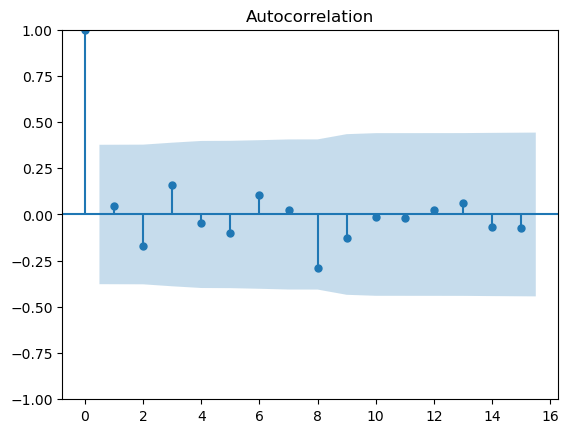

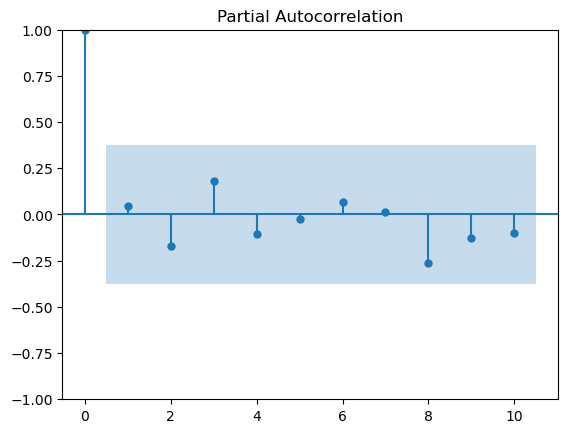

In [77]:
# Evaluation: we observe that residuals are random and resembles white noise.
print(plt.plot(sarima_result2.resid))
print(plot_acf(sarima_result2.resid))
print(plot_pacf(sarima_result2.resid, lags=10))

### Understanding SARIMAX models

1. Adding a differenced term makes the AIC better, but makes the prediction skewed because of the impact of covid. Do we want this skew?
2. Adding an exogenous factor (simple exogenous factor of whether there is covid or not) does not necessarily make the model better. However, we should logically take that into account.

### What does this mean?

We created many models, each with its strengths and weaknesses.

If the sales data is available, we should definitely use linear regression for prediction due to the similarity of the calculated yoy sales data to the reported values (which we are trying to predict).

In the case where we are predicting into the future, we may want to combine multiple models together:
- SARIMA model uses previous data from COVID-19, so it takes into account the noise/repercussions of covid-19. Adding exogenous factors helps us model away from the noise that happened DURING COVID-19. We could also account for other consumer trends such as consumer sentiment.
- For the model involving consumer sentiment, even though the evaluation results are not favourable (and hence we did not pick it for this forecast), it makes a lot of sense to add them into the model. Even though they may not help during the noisy COVID-19 period, they may be very helpful when the situation stabilizes, ie after 2023?

# Question 3

Factors affecting decision to close:
1. Declining sales (change in percentage). This includes change in sales from previous year and 
2. Declining sales (real quantity)
3. At close proximity to other similar stores
4. Size of the store (in terms of sales)
5. Flagship store (we later realized all our candidates are not flagship stores, so it will not be used)
6. Urban or suburban environment. Usually, we may choose to close some urban locations because of the rental cost and the availability of amazon (faster delivery for urban environments). Thats said, we definitely need to keep some urban locations for branding (eg flagship stores).
7. Population density using census data
8. Most impacted by covid (eg unemployment rate)

Given the large number of factors, we primarily look at the declining sales first before taking other factors into account.


In [78]:
# First, we examine the webscraped data
webscrape_data = pd.read_csv('system2_case_study_webscrape_data_locations.csv')
webscrape_data.head()

address  as_of_date          city           phone  \
0         13477 Middlebelt Road  2024-10-07       Livonia  (734) 666-3019   
1           5114 28th Street SE  2024-10-07  Grand Rapids  (616) 365-5419   
2            2677 Oak Valley Dr  2024-10-07     Ann Arbor  (734) 519-5591   
3  3000 White Bear Avenue North  2024-10-07     Maplewood  (612) 428-0697   
4         2560 Lemay Ferry Road  2024-10-07   Saint Louis  (314) 396-2245   

       state  location_id                                     store_services  \
0   Michigan          539  In-Store Shopping | In-Store Pickup | Curbside...   
1   Michigan         4107  In-Store Shopping | In-Store Pickup | Curbside...   
2   Michigan         4111  In-Store Shopping | In-Store Pickup | Curbside...   
3  Minnesota         1138  In-Store Shopping | In-Store Pickup | Curbside...   
4   Missouri         5163  In-Store Shopping | In-Store Pickup | Curbside...   

                        title  \
0             Livonia Commons   
1           Waterfall Shoppes   
2            Oak Valley Plaza   
3  Plaza 3000 Shopping Center   
4                 Lemay Plaza   

                                                 url  zipcode  postcode  \
0  https://stores.partycity.com/us/mi/livonia/par...    48150     48150   
1  https://stores.partycity.com/us/mi/grandrapids...    49512     49512   
2  https://stores.partycity.com/us/mi/annarbor/pa...    48103     48103   
3  https://stores.partycity.com/us/mn/maplewood/p...    55109     55109   
4  https://stores.partycity.com/us/mo/saintlouis/...    63125     63125   

    latitude  longitude  
0  42.381156 -83.335770  
1  42.910841 -85.540782  
2  42.247490 -83.768959  
3  45.032238 -93.014647  
4  38.518385 -90.305049

In [79]:
# Feature engineering flagship
webscrape_data['flagship'] = webscrape_data['store_services'].apply(lambda x: 1 if 'Flag Ship' in x else 0)
webscrape_data['flagship'].value_counts()

# 38 flagship stores across the states

flagship
0    709
1     38
Name: count, dtype: int64

In [80]:
webscrape_data.zipcode.value_counts().head()

zipcode
7652     2
33186    2
60714    2
48150    1
33323    1
Name: count, dtype: int64

In [81]:
# We want to investigate these zipcodes first due to their close proximity to each other:
webscrape_data[webscrape_data['zipcode'] == 7652]

address  as_of_date     city           phone       state  \
254    165 Route-4 West  2024-10-07  Paramus  (201) 345-2896  New Jersey   
352  669 South Route 17  2024-10-07  Paramus  (201) 345-2514  New Jersey   

     location_id                                     store_services  \
254          745  In-Store Shopping | In-Store Pickup | Curbside...   
352          746  In-Store Shopping | In-Store Pickup | Curbside...   

                          title  \
254  The Kohl's Shopping Center   
352                  S Route 17   

                                                   url  zipcode  postcode  \
254  https://stores.partycity.com/us/nj/paramus/par...     7652      7652   
352  https://stores.partycity.com/us/nj/paramus/par...     7652      7652   

      latitude  longitude  flagship  
254  40.917776 -74.056723         0  
352  40.966577 -74.078926         0

In [82]:
# We examine the shape, there are 747 (unique) stores. This is much less than the previously inspected location file (898).
webscrape_data.shape

(747, 14)

In [83]:
# We do not wish to consider short_duration_locations even if they are still open, because their yoy change has yet to be observed.
# In this case, we remove location_id 339 also because our location csv shows it is already closed in 2022. 

df = webscrape_data[~webscrape_data['location_id'].isin(short_duration_locations)]

# Filtering data that has not been considered.
print(len(df[~df['location_id'].isin(transaction.locationid)]))
df = df[df['location_id'].isin(transaction.locationid)]

115


There are 115 locationids which did not appear in location and transaction data. We do not have the benchmarks (growth rate and value) to evaluate them, so we will not consider them in the list to be removed. However, we may take them into consideration for evaluating the proximity of nearby stores.

In [84]:
# Checking cases where locations are not included in the stores
multiple_store_locations = df[~df['location_id'].isin(unique_store)]['location_id'].tolist()
multiple_store_locations

[23, 15, 175, 10, 16, 579, 105, 320, 3, 118, 291, 103, 21, 726]

Note about these multiple stores:
- 2nd 23 location closed in 2020.
- 2nd 175 location closed in 2022
- 2nd and 3rd 3 location closed in 2020 and 2022 respectively
- 2nd 726 location closed in 2021.

All other stores have been open together since 2022. In that case, we will investigate on a case by case basis if it appears within the suggested list

In [86]:
annual_sales = transaction[transaction.locationid.isin(df['location_id'])].set_index('period_end')
annual_sales = annual_sales.groupby('locationid').resample('Y')['amount'].sum().reset_index()
# Calculate the difference from the previous year within each location
annual_sales['diff'] = annual_sales.groupby('locationid')['amount'].diff()

# Calculate the percentage change from the previous year within each location
annual_sales['pct_change'] = annual_sales.groupby('locationid')['amount'].pct_change(periods=1) * 100

# We also calculate the percentage change from before covid (ie 4 years ago), is such data exist we can identify a better trend.
# Note this won't be used as a main identifier because not every store has this data.
annual_sales['pct_change_4'] = annual_sales.groupby('locationid')['amount'].pct_change(periods=4) * 100

In [87]:
annual_sales['diff_prev'] = annual_sales.groupby('locationid')['diff'].shift(1)
annual_sales['pct_change_prev'] = annual_sales.groupby('locationid')['pct_change'].shift(1)
annual_sales.head(20)

locationid period_end         amount          diff  pct_change  \
0            3 2019-12-31   54341.338687           NaN         NaN   
1            3 2020-12-31   81190.788097  26849.449409   49.408885   
2            3 2021-12-31  113553.681556  32362.893459   39.860302   
3            3 2022-12-31   71232.158245 -42321.523311  -37.270058   
4            3 2023-12-31   71553.567382    321.409138    0.451214   
5            4 2019-12-31   33944.342671           NaN         NaN   
6            4 2020-12-31   59450.374044  25506.031373   75.140743   
7            4 2021-12-31   96269.692530  36819.318486   61.932863   
8            4 2022-12-31   62378.696365 -33890.996164  -35.204222   
9            4 2023-12-31   46428.794948 -15949.901418  -25.569469   
10          10 2019-12-31   31403.789536           NaN         NaN   
11          10 2020-12-31   49029.309140  17625.519604   56.125454   
12          10 2021-12-31   54240.684267   5211.375127   10.629102   
13          10 2022-12-31   70037.225237  15796.540970   29.123049   
14          10 2023-12-31   60741.152382  -9296.072854  -13.273046   
15          15 2019-12-31   17039.063439           NaN         NaN   
16          15 2020-12-31   25080.969983   8041.906544   47.196881   
17          15 2021-12-31   45571.798295  20490.828312   81.698708   
18          15 2022-12-31   43207.960955  -2363.837340   -5.187062   
19          15 2023-12-31   14052.619149 -29155.341806  -67.476782   

    pct_change_4     diff_prev  pct_change_prev  
0            NaN           NaN              NaN  
1            NaN           NaN              NaN  
2            NaN  26849.449409        49.408885  
3            NaN  32362.893459        39.860302  
4      31.674282 -42321.523311       -37.270058  
5            NaN           NaN              NaN  
6            NaN           NaN              NaN  
7            NaN  25506.031373        75.140743  
8            NaN  36819.318486        61.932863  
9      36.779184 -33890.996164       -35.204222  
10           NaN           NaN              NaN  
11           NaN           NaN              NaN  
12           NaN  17625.519604        56.125454  
13           NaN   5211.375127        10.629102  
14     93.419817  15796.540970        29.123049  
15           NaN           NaN              NaN  
16           NaN           NaN              NaN  
17           NaN   8041.906544        47.196881  
18           NaN  20490.828312        81.698708  
19    -17.527045  -2363.837340        -5.187062

In [88]:
annual_sales_final = annual_sales[annual_sales['period_end'] == '2023-12-31']
annual_sales_final['pct_change_avg'] = (annual_sales_final['pct_change'] + annual_sales_final['pct_change_prev'])/2
annual_sales_final['diff_avg'] = (annual_sales_final['diff'] + annual_sales_final['diff_prev'])/2
annual_sales_final

locationid period_end        amount          diff  pct_change  \
4              3 2023-12-31  71553.567382    321.409138    0.451214   
9              4 2023-12-31  46428.794948 -15949.901418  -25.569469   
14            10 2023-12-31  60741.152382  -9296.072854  -13.273046   
19            15 2023-12-31  14052.619149 -29155.341806  -67.476782   
24            16 2023-12-31  54425.500005    -49.991720   -0.091769   
...          ...        ...           ...           ...         ...   
3113        6064 2023-12-31   9869.956776  -1114.969628  -10.149996   
3118        6065 2023-12-31   6777.671804    963.781157   16.577215   
3123        6066 2023-12-31   1626.713060   -132.578758   -7.535916   
3128        6068 2023-12-31   5624.656132  -3905.887723  -40.982842   
3133        6071 2023-12-31   9621.998463  -5956.582970  -38.235721   

      pct_change_4     diff_prev  pct_change_prev  pct_change_avg  \
4        31.674282 -42321.523311       -37.270058      -18.409422   
9        36.779184 -33890.996164       -35.204222      -30.386845   
14       93.419817  15796.540970        29.123049        7.925002   
19      -17.527045  -2363.837340        -5.187062      -36.331922   
24      556.896716  35597.442082       188.565253       94.236742   
...            ...           ...              ...             ...   
3113    180.055266   2046.382171        22.893909        6.371956   
3118    193.295283   1493.012450        34.553449       25.565332   
3123    399.367345    618.348732        54.196282       23.330183   
3128    235.463522   3666.735601        62.531642       10.774400   
3133    270.305312   9203.143213       144.353108       53.058693   

          diff_avg  
4    -21000.057087  
9    -24920.448791  
14     3250.234058  
19   -15759.589573  
24    17773.725181  
...            ...  
3113    465.706272  
3118   1228.396803  
3123    242.884987  
3128   -119.576061  
3133   1623.280121  

[627 rows x 10 columns]

In [89]:
annual_sales_final.sort_values('pct_change_4').head(20).reset_index(drop=True)

locationid period_end        amount          diff  pct_change  \
0          530 2023-12-31   1614.576415 -13350.533241  -89.211062   
1          511 2023-12-31  11299.529906 -44574.552512  -79.776796   
2          760 2023-12-31   1118.742224  -1344.007771  -54.573455   
3          522 2023-12-31  12090.907621 -21490.945090  -63.995710   
4          491 2023-12-31    470.913205    -12.315474   -2.548581   
5          541 2023-12-31  14754.246788 -22366.066825  -60.252904   
6          711 2023-12-31   7425.451734  -9591.740986  -56.365002   
7         1521 2023-12-31   7400.625100  -9899.813707  -57.222905   
8          529 2023-12-31  20862.111734 -31511.461604  -60.166721   
9          813 2023-12-31   6648.399434  -5380.646690  -44.730452   
10         105 2023-12-31  19945.475449 -33872.930387  -62.939305   
11         550 2023-12-31   9224.215012 -12245.346684  -57.035849   
12        1509 2023-12-31   8973.737119 -16440.990355  -64.690799   
13         560 2023-12-31  21538.172023 -12625.037926  -36.955069   
14         117 2023-12-31  61937.752502 -64123.087091  -50.866778   
15         521 2023-12-31  24840.387853 -15467.236721  -38.372980   
16         838 2023-12-31   5380.796636  -7402.219473  -57.906674   
17         551 2023-12-31  21052.650213 -14457.084408  -40.713017   
18         406 2023-12-31   9925.772904  -8832.339345  -47.085438   
19         519 2023-12-31  25371.719873 -31455.028256  -55.352504   

    pct_change_4      diff_prev  pct_change_prev  pct_change_avg      diff_avg  
0     -85.065573  -15407.290744       -50.727932      -69.969497 -14378.911992  
1     -77.317874  -80504.608782       -59.030196      -69.403496 -62539.580647  
2     -73.732964   -4203.505303       -63.056470      -58.814963  -2773.756537  
3     -58.665104  -20385.352446       -37.773593      -50.884652 -20938.148768  
4     -52.684925    -577.416809       -54.440132      -28.494357   -294.866142  
5     -52.402049  -25724.432087       -40.933306      -50.593105 -24045.249456  
6     -51.127111  -13954.507895       -45.055672      -50.710337 -11773.124440  
7     -47.000980  -22151.696835       -56.148283      -56.685594 -16025.755271  
8     -46.963900  -45646.765868       -46.568668      -53.367694 -38579.113736  
9     -46.384385  -11347.047083       -48.541247      -46.635849  -8363.846886  
10    -45.578349  -83404.130466       -60.780199      -61.859752 -58638.530426  
11    -45.489406  -10764.445064       -33.394685      -45.215267 -11504.895874  
12    -41.948498  -12402.172392       -32.795318      -48.743058 -14421.581374  
13    -40.540990  -42520.602417       -55.449255      -46.202162 -27572.820172  
14    -40.316269 -118642.325177       -48.484181      -49.675479 -91382.706134  
15    -39.102261  -29492.587144       -42.252862      -40.312921 -22479.911933  
16    -38.257501   -7956.258327       -38.363243      -48.134959  -7679.238900  
17    -38.211430  -39773.522940       -52.831830      -46.772424 -27115.303674  
18    -38.118974  -11920.726694       -38.856512      -42.970975 -10376.533019  
19    -35.458102  -42296.909216       -42.670852      -49.011678 -36875.968736

In [90]:
annual_sales_final.sort_values('diff').head(20).reset_index(drop=True)

locationid period_end         amount          diff  pct_change  \
0          117 2023-12-31   61937.752502 -64123.087091  -50.866778   
1          520 2023-12-31   89188.260746 -58724.280608  -39.702029   
2          103 2023-12-31   55608.737219 -49242.156917  -46.963984   
3          118 2023-12-31   45382.375014 -48364.284774  -51.590409   
4          511 2023-12-31   11299.529906 -44574.552512  -79.776796   
5          710 2023-12-31   61985.347357 -42319.299104  -40.572784   
6          105 2023-12-31   19945.475449 -33872.930387  -62.939305   
7          427 2023-12-31   24408.068703 -33245.248651  -57.664069   
8          411 2023-12-31   60684.840204 -33091.896872  -35.287959   
9          529 2023-12-31   20862.111734 -31511.461604  -60.166721   
10         519 2023-12-31   25371.719873 -31455.028256  -55.352504   
11         413 2023-12-31   62845.664128 -29298.723617  -31.796536   
12          15 2023-12-31   14052.619149 -29155.341806  -67.476782   
13         102 2023-12-31   45770.237621 -26499.695460  -36.667663   
14         527 2023-12-31   36459.911024 -24723.811009  -40.409132   
15         514 2023-12-31   42061.484894 -24195.222945  -36.517394   
16         761 2023-12-31  155211.067795 -23814.442847  -13.302262   
17         421 2023-12-31   20185.721679 -23423.755135  -53.712534   
18         541 2023-12-31   14754.246788 -22366.066825  -60.252904   
19         408 2023-12-31   30498.795286 -21623.098069  -41.485634   

    pct_change_4      diff_prev  pct_change_prev  pct_change_avg  \
0     -40.316269 -118642.325177       -48.484181      -49.675479   
1     -15.461976 -144614.302503       -49.436250      -44.569140   
2     -24.363678  -59642.103142       -36.258141      -41.611062   
3     -27.975982  -88396.997160       -48.531472      -50.060940   
4     -77.317874  -80504.608782       -59.030196      -69.403496   
5     -23.963924  -86902.957704       -45.449530      -43.011157   
6     -45.578349  -83404.130466       -60.780199      -61.859752   
7     -10.711513  -25755.648044       -30.878753      -44.271411   
8      10.222929  -36118.004689       -27.805594      -31.546777   
9     -46.963900  -45646.765868       -46.568668      -53.367694   
10    -35.458102  -42296.909216       -42.670852      -49.011678   
11      9.147197  -44868.164315       -32.747485      -32.272010   
12    -17.527045   -2363.837340        -5.187062      -36.331922   
13    248.317854  -31345.153968       -30.251535      -33.459599   
14      0.033062  -29725.842184       -32.698256      -36.553694   
15    -17.469089  -66907.729553       -50.244443      -43.380918   
16    181.670483   30837.362800        20.809601        3.753670   
17     63.357586   22055.902744       102.330605       24.309035   
18    -52.402049  -25724.432087       -40.933306      -50.593105   
19    -15.687726  -36729.964754       -41.338432      -41.412033   

         diff_avg  
0   -91382.706134  
1  -101669.291555  
2   -54442.130030  
3   -68380.640967  
4   -62539.580647  
5   -64611.128404  
6   -58638.530426  
7   -29500.448347  
8   -34604.950781  
9   -38579.113736  
10  -36875.968736  
11  -37083.443966  
12  -15759.589573  
13  -28922.424714  
14  -27224.826596  
15  -45551.476249  
16    3511.459976  
17    -683.926195  
18  -24045.249456  
19  -29176.531411

In [91]:
annual_sales_final.sort_values('pct_change')

locationid period_end        amount          diff  pct_change  \
840          530 2023-12-31   1614.576415 -13350.533241  -89.211062   
780          511 2023-12-31  11299.529906 -44574.552512  -79.776796   
19            15 2023-12-31  14052.619149 -29155.341806  -67.476782   
1540         822 2023-12-31   3094.475839  -6286.608721  -67.013667   
2453        1509 2023-12-31   8973.737119 -16440.990355  -64.690799   
...          ...        ...           ...           ...         ...   
2187        1079 2023-12-31   4461.610938   3102.210965  228.204430   
3073        6042 2023-12-31  13959.936166   9757.552604  232.190909   
595          440 2023-12-31   4332.439135   3046.186999  236.826584   
2013        1025 2023-12-31   1202.064336   1030.180656  599.347568   
1650         868 2023-12-31   6585.970595   5723.769820  663.855796   

      pct_change_4     diff_prev  pct_change_prev  pct_change_avg  \
840     -85.065573 -15407.290744       -50.727932      -69.969497   
780     -77.317874 -80504.608782       -59.030196      -69.403496   
19      -17.527045  -2363.837340        -5.187062      -36.331922   
1540    -25.750471  -1839.531575       -16.394212      -41.703939   
2453    -41.948498 -12402.172392       -32.795318      -48.743058   
...            ...           ...              ...             ...   
2187           NaN    214.356583        18.720389      123.462410   
3073    551.393245    -82.068077        -1.915486      115.137712   
595    1517.143498   -807.649246       -38.571504       99.127540   
2013           NaN    -50.814186       -22.817545      288.265011   
1650    389.401653   -883.223500       -50.602224      306.626786   

          diff_avg  
840  -14378.911992  
780  -62539.580647  
19   -15759.589573  
1540  -4063.070148  
2453 -14421.581374  
...            ...  
2187   1658.283774  
3073   4837.742264  
595    1119.268876  
2013    489.683235  
1650   2420.273160  

[627 rows x 10 columns]

In [92]:
annual_sales[annual_sales['period_end'] == '2023-12-31'].sort_values('pct_change').locationid[:10].tolist()

[530, 511, 15, 822, 1509, 522, 105, 1510, 726, 541]

From most decline post-covid (pct_change_4), our candidates are:
- 530, 511, 760, 522, 491, 541, 711, 1521, 529, 813

From the most decline in sales from previous year, our candidates are:
- 117, 520, 103, 118, 511, 710, 105, 427, 411, 529

From the most pct decline in sales from previous year, our candidates are:
- 530, 511, 15, 822, 1509, 522, 105, 1510, 726, 541

Many of these candidates overlap (they are identified as candidates in many categories), and that may suggest they need to be investigated first.

In [93]:
all_candidates = [530, 511, 760, 522, 491, 541, 711, 1521, 529, 813, 117, 520, 103, 118, 511, 710, 105, 427, 411, 529,530, 511, 15, 822, 1509, 522, 105, 1510, 726, 541]

In [94]:
# Checking which candidate appeared many times.
pd.Series(all_candidates).value_counts().head(10)

511     3
530     2
522     2
541     2
529     2
105     2
710     1
1510    1
1509    1
822     1
Name: count, dtype: int64

In [95]:
candidate_sales = annual_sales_final[annual_sales_final['locationid'].isin(all_candidates)].sort_values('locationid').reset_index(drop=True)
candidate_sales

locationid period_end        amount          diff  pct_change  \
0           15 2023-12-31  14052.619149 -29155.341806  -67.476782   
1          103 2023-12-31  55608.737219 -49242.156917  -46.963984   
2          105 2023-12-31  19945.475449 -33872.930387  -62.939305   
3          117 2023-12-31  61937.752502 -64123.087091  -50.866778   
4          118 2023-12-31  45382.375014 -48364.284774  -51.590409   
5          411 2023-12-31  60684.840204 -33091.896872  -35.287959   
6          427 2023-12-31  24408.068703 -33245.248651  -57.664069   
7          491 2023-12-31    470.913205    -12.315474   -2.548581   
8          511 2023-12-31  11299.529906 -44574.552512  -79.776796   
9          520 2023-12-31  89188.260746 -58724.280608  -39.702029   
10         522 2023-12-31  12090.907621 -21490.945090  -63.995710   
11         529 2023-12-31  20862.111734 -31511.461604  -60.166721   
12         530 2023-12-31   1614.576415 -13350.533241  -89.211062   
13         541 2023-12-31  14754.246788 -22366.066825  -60.252904   
14         710 2023-12-31  61985.347357 -42319.299104  -40.572784   
15         711 2023-12-31   7425.451734  -9591.740986  -56.365002   
16         726 2023-12-31   8041.109776 -12244.690149  -60.360894   
17         760 2023-12-31   1118.742224  -1344.007771  -54.573455   
18         813 2023-12-31   6648.399434  -5380.646690  -44.730452   
19         822 2023-12-31   3094.475839  -6286.608721  -67.013667   
20        1509 2023-12-31   8973.737119 -16440.990355  -64.690799   
21        1510 2023-12-31   4565.926426  -7292.160219  -61.495252   
22        1521 2023-12-31   7400.625100  -9899.813707  -57.222905   

    pct_change_4      diff_prev  pct_change_prev  pct_change_avg  \
0     -17.527045   -2363.837340        -5.187062      -36.331922   
1     -24.363678  -59642.103142       -36.258141      -41.611062   
2     -45.578349  -83404.130466       -60.780199      -61.859752   
3     -40.316269 -118642.325177       -48.484181      -49.675479   
4     -27.975982  -88396.997160       -48.531472      -50.060940   
5      10.222929  -36118.004689       -27.805594      -31.546777   
6     -10.711513  -25755.648044       -30.878753      -44.271411   
7     -52.684925    -577.416809       -54.440132      -28.494357   
8     -77.317874  -80504.608782       -59.030196      -69.403496   
9     -15.461976 -144614.302503       -49.436250      -44.569140   
10    -58.665104  -20385.352446       -37.773593      -50.884652   
11    -46.963900  -45646.765868       -46.568668      -53.367694   
12    -85.065573  -15407.290744       -50.727932      -69.969497   
13    -52.402049  -25724.432087       -40.933306      -50.593105   
14    -23.963924  -86902.957704       -45.449530      -43.011157   
15    -51.127111  -13954.507895       -45.055672      -50.710337   
16    275.265982  -16804.484340       -45.306971      -52.833932   
17    -73.732964   -4203.505303       -63.056470      -58.814963   
18    -46.384385  -11347.047083       -48.541247      -46.635849   
19    -25.750471   -1839.531575       -16.394212      -41.703939   
20    -41.948498  -12402.172392       -32.795318      -48.743058   
21    108.975444   -1320.741387       -10.021691      -35.758471   
22    -47.000980  -22151.696835       -56.148283      -56.685594   

         diff_avg  
0   -15759.589573  
1   -54442.130030  
2   -58638.530426  
3   -91382.706134  
4   -68380.640967  
5   -34604.950781  
6   -29500.448347  
7     -294.866142  
8   -62539.580647  
9  -101669.291555  
10  -20938.148768  
11  -38579.113736  
12  -14378.911992  
13  -24045.249456  
14  -64611.128404  
15  -11773.124440  
16  -14524.587244  
17   -2773.756537  
18   -8363.846886  
19   -4063.070148  
20  -14421.581374  
21   -4306.450803  
22  -16025.755271

In [96]:
candidate_df = webscrape_data[webscrape_data['location_id'].isin(all_candidates)].sort_values('location_id')
candidate_df

address  as_of_date              city  \
77        5651 West Touhy Avenue  2024-10-07             Niles   
505       9130 West Broad Street  2024-10-07          Richmond   
274     11218 Rodney Parham Road  2024-10-07       Little Rock   
687         2530 S Colorado Road  2024-10-07            Denver   
354       94-799 Lumiaina Street  2024-10-07           Waipahu   
327        4525 Commercial Drive  2024-10-07      New Hartford   
160               3850 Grand Ave  2024-10-07             Chino   
212   3000 Pablo Kisel Boulevard  2024-10-07       Brownsville   
677         32469 Gratiot Avenue  2024-10-07         Roseville   
564      1441 W Imperial Highway  2024-10-07          La Habra   
120    310-320 Baychester Avenue  2024-10-07             Bronx   
268              12220 Hall Road  2024-10-07  Sterling Heights   
587    3797-3849 Nostrand Avenue  2024-10-07          Brooklyn   
592  3060 Baldwin Park Boulevard  2024-10-07      Baldwin Park   
646                     385 NJ-3  2024-10-07           Clifton   
8         3149 Kennedy Boulevard  2024-10-07      North Bergen   
728     888 North Nimitz Highway  2024-10-07          Honolulu   
474         42800 Jackson Avenue  2024-10-07             Indio   
16       1171 N. National Avenue  2024-10-07          Columbus   
665   2410 Laporte Ave Suite 150  2024-10-07        Valparaiso   
61     338 South Mountain Avenue  2024-10-07            Upland   
196      27588 W. Lugonia Avenue  2024-10-07          Redlands   
65      12076 Lakewood Boulevard  2024-10-07            Downey   

              phone       state  location_id  \
77   (224) 601-5692    Illinois           15   
505  (804) 346-8600    Virginia          103   
274  (501) 223-4929    Arkansas          105   
687  (303) 731-1483    Colorado          117   
354  (808) 671-3133      Hawaii          118   
327  (315) 275-2296    New York          411   
160  (909) 413-6816  California          427   
212  (956) 517-1614       Texas          491   
677  (586) 800-5262    Michigan          511   
564  (562) 217-4475  California          520   
120  (917) 688-3961    New York          522   
268  (586) 722-1358    Michigan          529   
587  (347) 378-0985    New York          530   
592  (626) 655-4769  California          541   
646  (862) 414-8164  New Jersey          710   
8    (201) 381-5766  New Jersey          711   
728  (808) 599-7591      Hawaii          726   
474  (442) 300-9960  California          760   
16   (812) 799-2813     Indiana          813   
665  (219) 246-4406     Indiana          822   
61   (909) 297-1352  California         1509   
196  (909) 255-0827  California         1510   
65   (562) 392-8259  California         1521   

                                        store_services  \
77   In-Store Shopping | In-Store Pickup | Curbside...   
505  In-Store Shopping | In-Store Pickup | Curbside...   
274  In-Store Shopping | In-Store Pickup | Curbside...   
687  In-Store Shopping | In-Store Pickup | Curbside...   
354                                  In-Store Shopping   
327  In-Store Shopping | In-Store Pickup | Curbside...   
160  In-Store Shopping | In-Store Pickup | Curbside...   
212  In-Store Shopping | In-Store Pickup | Curbside...   
677  In-Store Shopping | In-Store Pickup | Curbside...   
564  In-Store Shopping | In-Store Pickup | Curbside...   
120  In-Store Shopping | In-Store Pickup | Curbside...   
268  In-Store Shopping | In-Store Pickup | Curbside...   
587  In-Store Shopping | In-Store Pickup | Curbside...   
592  In-Store Shopping | In-Store Pickup | Curbside...   
646  In-Store Shopping | In-Store Pickup | Curbside...   
8    In-Store Shopping | In-Store Pickup | Schedule...   
728                                  In-Store Shopping   
474  In-Store Shopping | In-Store Pickup | Curbside...   
16   In-Store Shopping | In-Store Pickup | Curbside...   
665  In-Store Shopping | In-Store Pickup | Curbside...   
61   In-Store Shopping | In-Store Pickup | Curbside...   
196  In-Sto

### A few locations the company that would certainly close.

1. First, we choose 530. It experienced highest percentage decrease for both previous year sales and compared to precovid (4 years prior), dropping a whopping 90% in sales compared to previous year, -85% compared to precovid, and -50% for previous year (from 2021 to 2022). It is also located in brooklyn, with the closest store #404 being 2.5miles away. This store is not in the list so we can definitely close this store.

2. I would also choose to close 511. It ranks top 10 most negative for all 3 categories suggesting long-term underperformance, and it is located near other stores by car (closest is 48313, located 7.8 miles away), since the neighborhood is car-dominated.

3. I would also choose to close 522. It experienced 64% decrease in yoy annual sales -59% compared to pre-covid, and the previous year has been decreasing too. It is also located in Bronx with the closest store #860 (also not on the list) just 3.2 miles away.

In general, I would choose to consider locations that have experienced a significant decline in sales for the past few years (that are not flagship or the only store in the area). We also want to take note that if it is an extremely large store, we may reconsider closing it due to the logistics involved. We could use this logic to evaluate the other candidates.

With more context about the exact business model of Party City, target audience, etc., we can include other perimeters on deciding to close the store or not. (other built environment factors)

/Users/matticii/anaconda3/lib/python3.11/site-packages/_plotly_utils/basevalidators.py:106: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



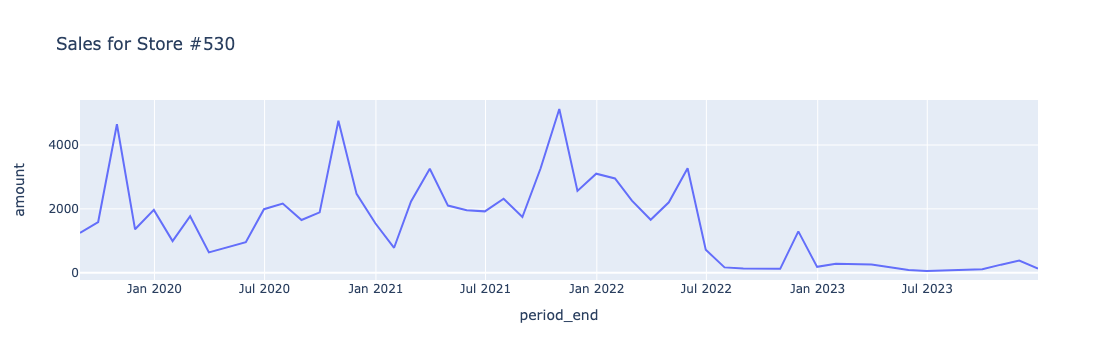

In [97]:
# Visualization
px.line(transaction[transaction['locationid'] == 530], x= 'period_end', y='amount',
       title = 'Sales for Store #530')

/Users/matticii/anaconda3/lib/python3.11/site-packages/_plotly_utils/basevalidators.py:106: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



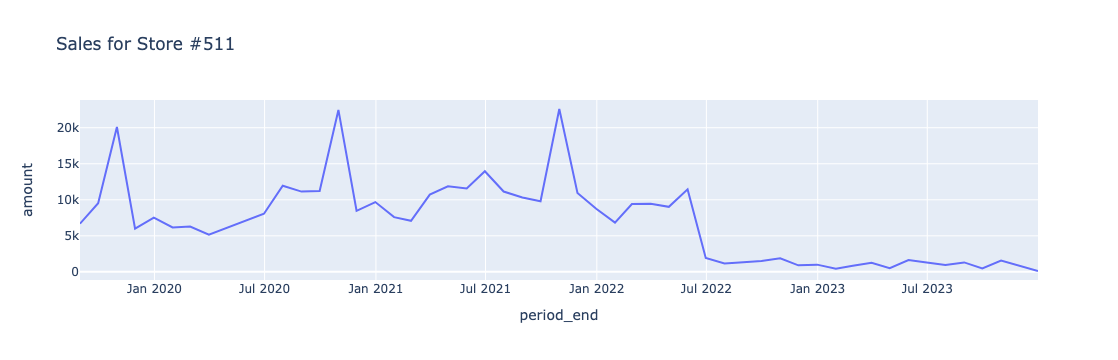

In [98]:
# Visualization
px.line(transaction[transaction['locationid'] == 511], x= 'period_end', y='amount',
       title = 'Sales for Store #511')

/Users/matticii/anaconda3/lib/python3.11/site-packages/_plotly_utils/basevalidators.py:106: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



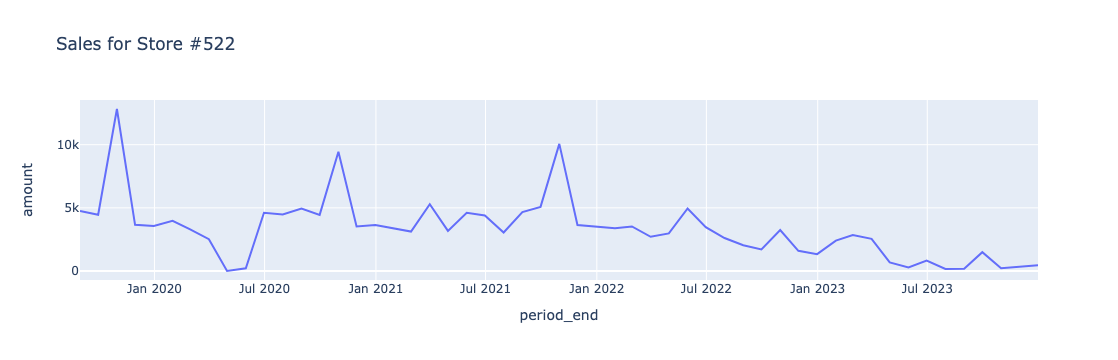

In [99]:
# Visualization
px.line(transaction[transaction['locationid'] == 522], x= 'period_end', y='amount',
       title = 'Sales for Store #522')

# Question 4

Party City is a leading retailer in a very specific niche—party supplies. Its strong brand recognition and extensive product offerings allow it to dominate a market that doesn't have many other major players. This specialization provides a significant competitive edge in capturing consumer demand for party-related goods and services. That said, it faces many challenges that may not warrant an investment.

Rise in online sales:
Party City operates within the broader context of declining brick-and-mortar retail, where foot traffic in physical stores has decreased significantly. The secular shift towards e-commerce has negatively affected its sales, particularly given that more consumers are comfortable purchasing party supplies from online competitors such as Amazon or specialty websites. This places Party City in a challenging position, as its physical presence involves higher operating costs compared to e-commerce platforms.

- In 2021, 14.1% of Party City's total retail sales were digitally-enabled, including Buy Online, Pick-Up In Store, curbside pickup, and delivery. This suggests that the majority of retail sales (85.9%) were from traditional in-store purchases. While they may have made shifts since COVID-19, their core business definitely remains in the store (and the costs associated with running the stores). It will be a slow and painful transition.
- Party City's e-commerce revenue for 2023 was estimated at 198.9 million. While this is a significant amount, it's important to note that Party City's total revenue for 2021 was 2.17 billion, indicating that e-commerce sales represent a relatively small portion of overall revenue.

Source: 
https://s2.q4cdn.com/832897007/files/doc_financials/2021/annual/PRTY-2021-Annual-Report.pdf ;
https://ecommercedb.com/store/partycity.com
   
- Prices may be somewhat more competitive than Amazon (after discount), but not sure about in-person purchase.


Economic cycle:
We have observed rather strange economic cycles since the COVID-19 pandemic. Post-pandemic, our economy is not doing so well and the consumer confidence is struggling. Party products, being non-essential consumer goods, are the most prone to such changes.
- CCI has declined to around 99.0 (long term = 100)
- Consumer sentiment (by UMICH) has declined to 70+ compared to close to 100 in 2019.
- Savings rate dropped to less than 3% (compared to around 7% in the same period in 2019) (St. Louis FED).

Using the long-term CCI, we observe that consumer confidence is expected to rise should there be no black swan events in the next few years, similar to what happened in the post-2008 financial crisis. However, party products are likely the last thing to significantly increase in sales, as consumers will likely remain cautiously optimistic in the next two years or so, as the economy (and people's incoming/savings) strives to recover.

Reasons why we should still look out for Party City in the long run.
- It is the US's leading party product retailer, capable of handling bankruptcy.
- It has been trying to revolutionize its products and in-store experiences, though the impact of this has yet to be seen
  
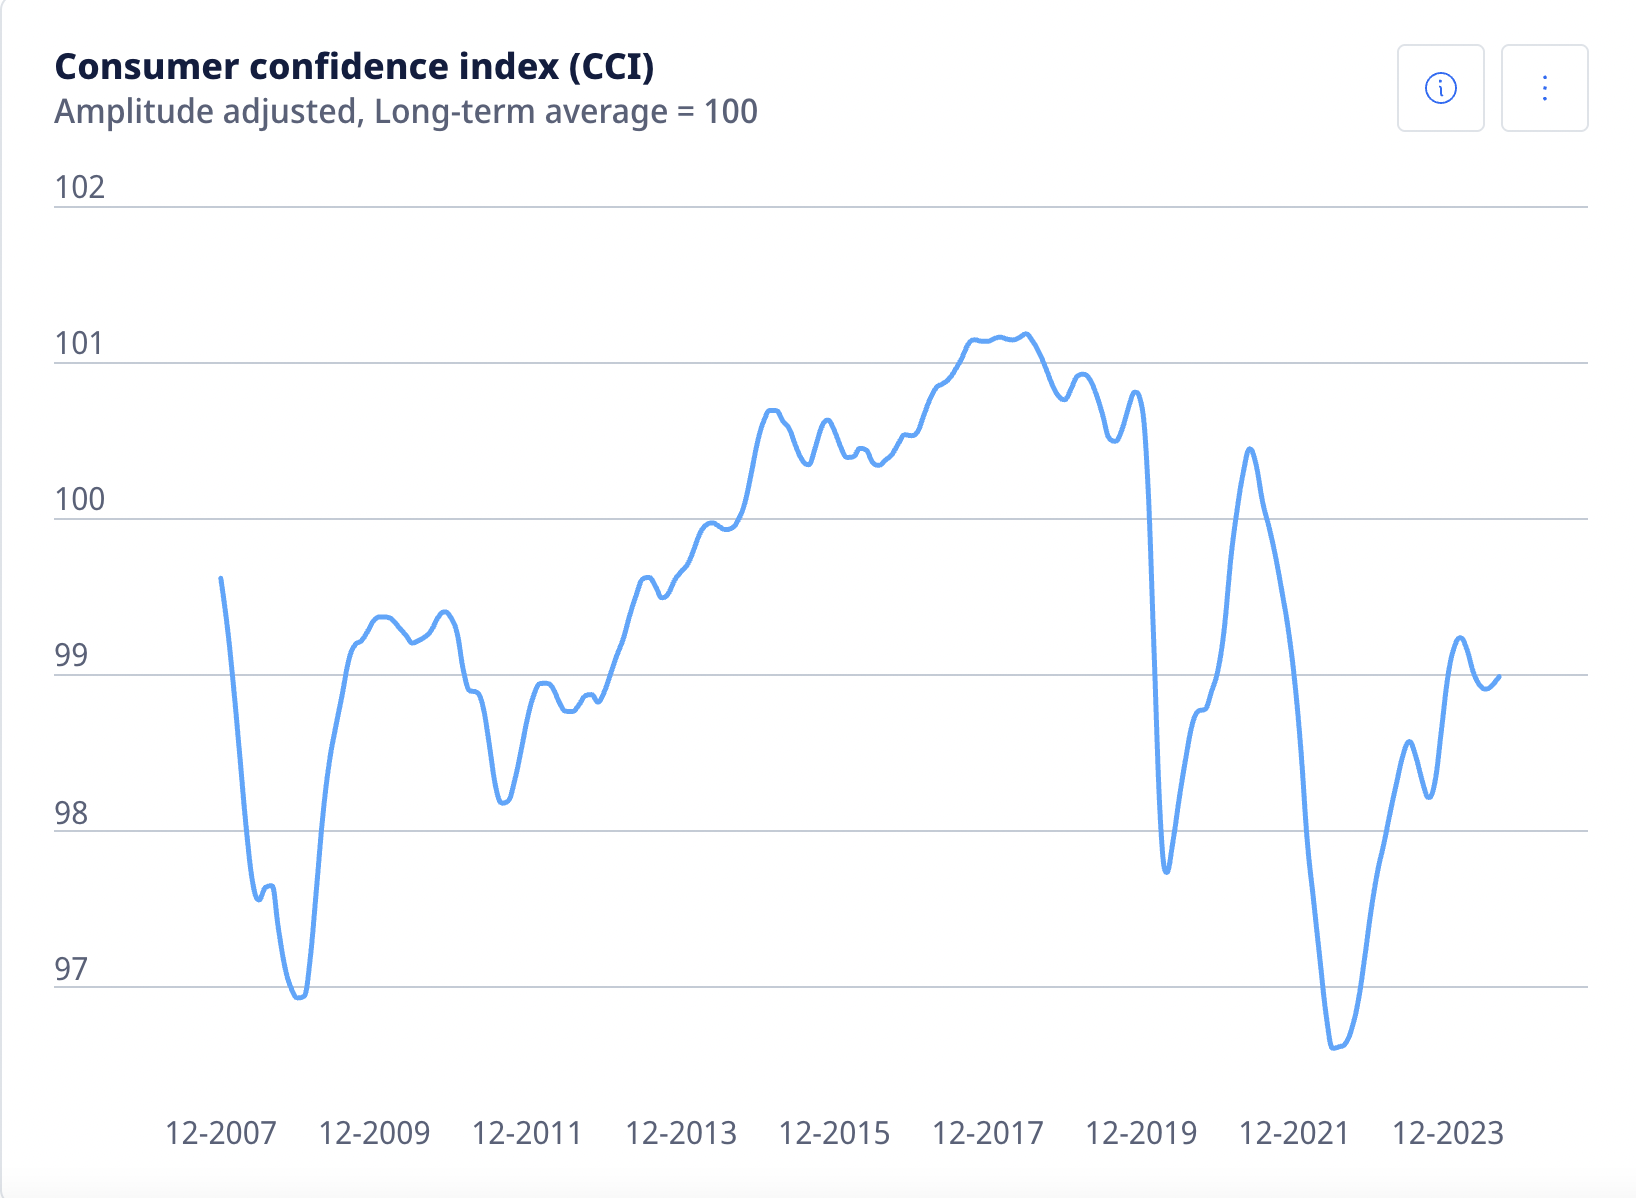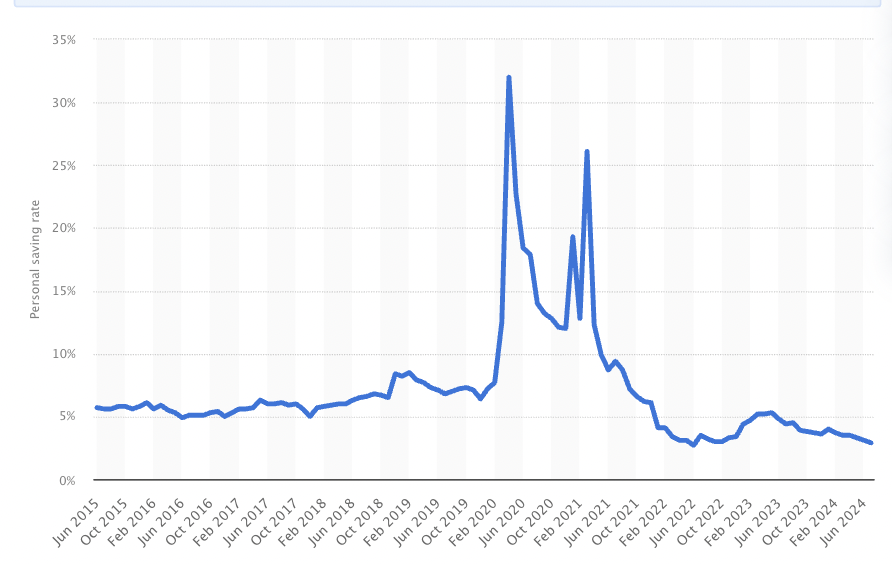


/Users/matticii/anaconda3/lib/python3.11/site-packages/_plotly_utils/basevalidators.py:106: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



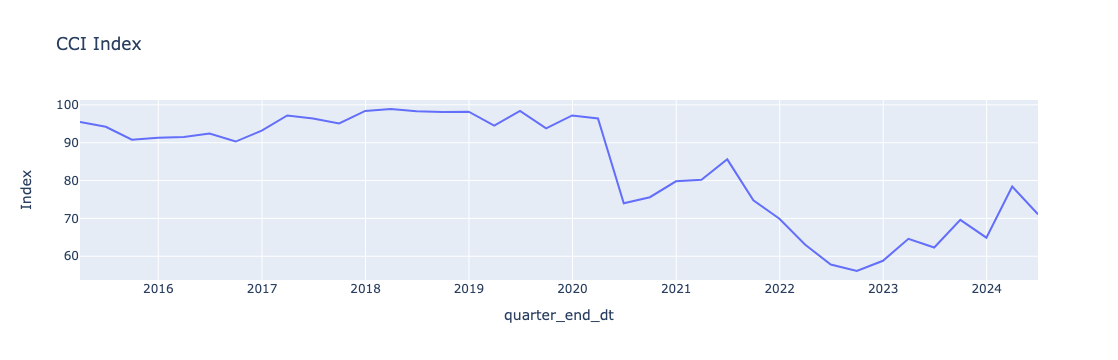

In [100]:
# Macroeconomic trends: consumer behavior.
# First, we notice significant fluctuations in consumer sentiments
quarter_end_month_map = {1: '03-31', 2: '06-30', 3: '09-30', 4: '12-31'}

# Create a 'quarter_end_date' column by combining year and the last day of the quarter
consumer_sent15['quarter_end_dt'] = pd.to_datetime(consumer_sent15['Year'].astype(str) + "-" + 
                                                    consumer_sent15['Quarter'].map(quarter_end_month_map))

px.line(consumer_sent15, x='quarter_end_dt', y = 'Index',
       title = 'Consumer Sentiment Index')

In [101]:
annual_sales_final

locationid period_end        amount          diff  pct_change  \
4              3 2023-12-31  71553.567382    321.409138    0.451214   
9              4 2023-12-31  46428.794948 -15949.901418  -25.569469   
14            10 2023-12-31  60741.152382  -9296.072854  -13.273046   
19            15 2023-12-31  14052.619149 -29155.341806  -67.476782   
24            16 2023-12-31  54425.500005    -49.991720   -0.091769   
...          ...        ...           ...           ...         ...   
3113        6064 2023-12-31   9869.956776  -1114.969628  -10.149996   
3118        6065 2023-12-31   6777.671804    963.781157   16.577215   
3123        6066 2023-12-31   1626.713060   -132.578758   -7.535916   
3128        6068 2023-12-31   5624.656132  -3905.887723  -40.982842   
3133        6071 2023-12-31   9621.998463  -5956.582970  -38.235721   

      pct_change_4     diff_prev  pct_change_prev  pct_change_avg  \
4        31.674282 -42321.523311       -37.270058      -18.409422   
9        36.779184 -33890.996164       -35.204222      -30.386845   
14       93.419817  15796.540970        29.123049        7.925002   
19      -17.527045  -2363.837340        -5.187062      -36.331922   
24      556.896716  35597.442082       188.565253       94.236742   
...            ...           ...              ...             ...   
3113    180.055266   2046.382171        22.893909        6.371956   
3118    193.295283   1493.012450        34.553449       25.565332   
3123    399.367345    618.348732        54.196282       23.330183   
3128    235.463522   3666.735601        62.531642       10.774400   
3133    270.305312   9203.143213       144.353108       53.058693   

          diff_avg  
4    -21000.057087  
9    -24920.448791  
14     3250.234058  
19   -15759.589573  
24    17773.725181  
...            ...  
3113    465.706272  
3118   1228.396803  
3123    242.884987  
3128   -119.576061  
3133   1623.280121  

[627 rows x 10 columns]

In [102]:
# Calculate average yoy growth for all stores
# Stores have been losing money since covid19
print('Mean income compared to previous year: $', annual_sales_final['diff'].mean())
print('Mean difference for the year before: $', annual_sales_final['diff_prev'].mean())

Mean income compared to previous year: $ -2109.3068829440062
Mean difference for the year before: $ -1254.4176605587804


In [ ]:
# END